#After CP1GRU + Attention Mechanism

# Now Using BiGRU

In [ ]:
# File 1: Import libraries and normalize data

import numpy as np


full_data = np.loadtxt(fname='/content/drive/MyDrive/Datasets/CP1BiGRU/train_FD001.txt', dtype=np.float32)
full_test = np.loadtxt(fname='/content/drive/MyDrive/Datasets/CP1BiGRU/test_FD001.txt', dtype=np.float32)

#engineID and working time cycle
prefix_data = full_data[:, [0, 1]]
prefix_test = full_test[:, [0, 1]]

# op set and raw sensor data
inputs_data = full_data[:, 2:]
inputs_test = full_test[:, 2:]

# to avoid devide zero problem
eps = 1e-12

# standardization (Optional)
 # mu = np.mean(inputs, axis=0)
 # sigma = np.std(inputs, axis=0)
 # standard = (inputs - mu) / (sigma + eps)

min = np.min(inputs_data, axis=0)
max = np.max(inputs_data, axis=0)

normed_data = (inputs_data - min) / (max - min + eps)
normed_test = (inputs_test - min) / (max - min + eps)

output_data = np.concatenate((prefix_data, normed_data), axis=1)
output_test = np.concatenate((prefix_test, normed_test), axis=1)
np.savetxt('/content/drive/MyDrive/Datasets/CP1BiGRU/train_FD001_normed.txt', output_data, fmt='%f')
np.savetxt('/content/drive/MyDrive/Datasets/CP1BiGRU/test_FD001_normed.txt', output_test, fmt='%f')

In [ ]:
#File2: Dataset class

import torch
import numpy as np
import warnings
from torch.utils.data import Dataset

class Turbofandataset(Dataset):
    def __init__(self, mode='train', dataset=None, rul_result=None):
        self.data = np.loadtxt(fname=dataset, dtype=np.float32)
        self.data = np.delete(self.data, [5, 9, 10, 14, 20, 22, 23], axis=1)
        self.window_size = 30
        self.sample_num = int(self.data[-1][0])
        self.length = []
        self.mode = mode

        self.max_rul = 130 # Dataset onujayi change....

        if self.mode == 'test' and rul_result is not None:
            self.rul_result = np.loadtxt(fname=rul_result, dtype=np.float32)
        if self.mode == 'test' and rul_result is None:
            raise ValueError('the rul_result file path of the testset not specifyied, '
                             'please check if the parameters passed in are correct.')
        if self.mode != 'test' and self.mode != 'train':
            raise ValueError(' undefined mode is choosen, '
                             'please check if the parameters you passed in are correct.')
        if self.mode == 'train' and rul_result is not None:
            warnings.warn('This rul_result file will only be used in the test set, '
                          'and the current mode that selected is training, so the file will be ignored.')

        self.x = []
        self.mean_and_coef = []
        self.y = []

        if self.mode == 'train':
            for i in range(1, self.sample_num + 1):
                ind = np.where(self.data[:, 0] == i)

                #tuple ke n dim  array te transfer kora
                ind = ind[0]
                # single engine data
                data_temp = self.data[ind, :]
                for j in range(len(data_temp) - self.window_size + 1):
                    self.x.append(data_temp[j: j+self.window_size, 2:])
                    rul = len(data_temp) - self.window_size - j
                    if rul > self.max_rul:
                        rul = self.max_rul
                    self.y.append(rul)

        if self.mode == 'test':
            for i in range(1, self.sample_num + 1):
                ind = np.where(self.data[:, 0] == i)[0]
                data_temp = self.data[ind, :]

                '''
                    When the number of data for a turbofan engine on the testset is less than the window length,
                    an interpolation operation will be performed
                '''
                if len(data_temp) < self.window_size:
                    data = np.zeros((self.window_size, data_temp.shape[1]))
                    for j in range(data.shape[1]):
                        x_old = np.linspace(0, len(data_temp)-1, len(data_temp), dtype=np.float64)
                        params = np.polyfit(x_old, data_temp[:, j].flatten(), deg=1)
                        k = params[0]
                        b = params[1]
                        x_new = np.linspace(0, self.window_size-1, self.window_size, dtype=np.float64)
                        data[:, j] = (x_new * len(data_temp) / self.window_size * k + b)
                    self.x.append(data[-self.window_size:, 2:])
                else:
                    self.x.append(data_temp[-self.window_size:, 2:])
                rul = self.rul_result[i - 1]
                if rul > self.max_rul:
                    rul = self.max_rul
                self.y.append(rul)

        self.x =np.array(self.x)
        self.y= np.array(self.y)/self.max_rul
        for i in range(len(self.x)):
            one_sample = self.x[i]
            self.mean_and_coef.append(self.fea_extract(one_sample))

        mu = np.mean(self.mean_and_coef, axis=0)
        sigma = np.std(self.mean_and_coef, axis=0)
        eps = 1e-10
        self.mean_and_coef = (self.mean_and_coef - mu) / (sigma + eps)
        self.mean_and_coef = np.array(self.mean_and_coef)

    @staticmethod
    def fea_extract(data):
        fea = []
        x = np.array(range(data.shape[0]))
        for i in range(data.shape[1]):
            fea.append(np.mean(data[:, i]))
            fea.append(np.polyfit(x.flatten(), data[:, i].flatten(), deg=1)[0])
        return fea

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        x_tensor = torch.from_numpy(self.x[index]).to(torch.float32)
        y_tensor = torch.Tensor([self.y[index]]).to(torch.float32)
        handcrafted_features = torch.from_numpy(self.mean_and_coef[index]).to(torch.float32)
        return x_tensor, handcrafted_features, y_tensor

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

class Trainer:
    def __init__(self, model, model_optimizer, print_every, epochs=200, device='cpu', prefix='FD001'):
        self.model = model.to(device)
        self.model_optimizer = model_optimizer
        self.print_every = print_every
        self.epochs = epochs
        self.device = device
        self.criterion = torch.nn.MSELoss()
        self.prefix = prefix
        self.rmse_list = []

    def train_single_epoch(self, dataloader):
        running_loss = 0
        length = len(dataloader)
        for batch_index, data in enumerate(dataloader, 0):
            inputs, handcrafted_feature, labels = data
            inputs, handcrafted_feature, labels = inputs.to(self.device), handcrafted_feature.to(self.device), labels.to(self.device)
            self.model_optimizer.zero_grad()
            predictions = self.model(inputs, handcrafted_feature)
            loss = self.criterion(predictions, labels)
            running_loss += loss.item()
            loss.backward()
            self.model_optimizer.step()
            if (batch_index + 1) % self.print_every == 0:
                print('batch:{}/{}, loss(avg. on {} batches: {}'.format(batch_index + 1, length, self.print_every, running_loss / self.print_every))
                running_loss = 0

    def train(self, train_loader, test_loader, iteration):
        for epoch in range(self.epochs):
            print('Epoch: {}'.format(epoch + 1))
            self.model.train()
            self.train_single_epoch(train_loader)
            current_score, current_RMSE, predictions, labels = self.test(test_loader)
            self.rmse_list.append(current_RMSE)
            if epoch == 0:
                best_score = current_score
                best_RMSE = current_RMSE
            else:
                if current_score < best_score:
                    best_score = current_score
                    self.save_checkpoints(iteration + 1, epoch + 1, 'best_score')
                if current_RMSE < best_RMSE:
                    best_RMSE = current_RMSE
                    self.save_checkpoints(iteration + 1, epoch + 1, 'best_RMSE')
        self.plot_rmse_over_epochs()
        self.plot_results(labels, predictions)
        return float(best_score), float(best_RMSE)

    def save_checkpoints(self, iteration, epoch, which_type):
        state = {
            'iter': iteration,
            'epoch': epoch,
            'state_dict': self.model.state_dict(),
            'optim_dict': self.model_optimizer.state_dict()
        }
        torch.save(state, '/content/drive/MyDrive/DMLabProject/checkpoints/{}_iteration{}_{}.pth.tar'.format(self.prefix, iteration, which_type))
        print('{}_checkpoints saved successfully!'.format(which_type))

    @staticmethod
    def score(y_true, y_pred):
        score = 0
        y_true = y_true.cpu()
        y_pred = y_pred.cpu()
        for i in range(len(y_pred)):
            if y_true[i] <= y_pred[i]:
                score = score + np.exp(-(y_true[i] - y_pred[i]) / 10.0) - 1
            else:
                score = score + np.exp((y_true[i] - y_pred[i]) / 13.0) - 1
        return score

    def plot_results(self, labels, predictions):
        engine_ids = np.arange(1, len(labels) + 1)
        plt.figure(figsize=(12, 6))
        plt.plot(engine_ids, labels, label='True RUL', color='blue')
        plt.plot(engine_ids, predictions, label='Predicted RUL', linestyle='--', color='red')
        plt.xlabel('Engine ID')
        plt.ylabel('RUL')
        plt.title('Actual RUL vs. Predicted RUL')
        plt.legend()
        plt.show()

    def plot_rmse_over_epochs(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.rmse_list) + 1), self.rmse_list, marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.title('RMSE over Epochs')
        plt.show()

    def test(self, test_loader):
        score = 0
        loss = 0
        all_predictions = []
        all_labels = []
        self.model.eval()
        criterion = torch.nn.MSELoss()
        for batch_index, data in enumerate(test_loader, 0):
            with torch.no_grad():
                inputs, handcrafted_feature, labels = data
                inputs, handcrafted_feature, labels = inputs.to(self.device), handcrafted_feature.to(self.device), labels.to(self.device)
                predictions = self.model(inputs, handcrafted_feature)
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                score += self.score(labels.cpu() * 130, predictions.cpu() * 130)
                loss += criterion(labels.cpu() * 130, predictions.cpu() * 130) * len(labels)
        loss = (loss / len(test_loader.dataset)) ** 0.5
        print('test result: score: {}, RMSE: {}'.format(score.item(), loss))
        return score.item(), loss, np.array(all_predictions), np.array(all_labels)


In [ ]:
# File 4: Model and Attention3dBlock class
import torch
from torch import nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.gru = nn.GRU(batch_first=True, input_size=17, hidden_size=50, num_layers=1, bidirectional=True)
        self.attenion = Attention3dBlock()
        self.linear = nn.Sequential(
            nn.Linear(in_features=3000, out_features=50),  # we can adjust input features from 1500 to 3000
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=50, out_features=10),
            nn.ReLU(inplace=True)
        )
        self.handcrafted = nn.Sequential(
            nn.Linear(in_features=34, out_features=10),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2)
        )

        self.output = nn.Sequential(
            nn.Linear(in_features=20, out_features=1)
        )

    def forward(self, inputs, handcrafted_feature):
        y = self.handcrafted(handcrafted_feature)
        x, hn = self.gru(inputs)
        x = self.attenion(x)
        # flatten
        x = x.reshape(-1, 3000)  # we an adjust from 1500 to 3000
        x = self.linear(x)
        out = torch.concat((x, y), dim=1)
        out = self.output(out)
        return out



class Attention3dBlock(nn.Module):
    def __init__(self):
        # implementation of __init__ method
        super(Attention3dBlock, self).__init__()

        self.linear = nn.Sequential(
            nn.Linear(in_features=30, out_features=30),
            nn.Softmax(dim=2),
        )

    #inputs: batch size * window size(time step) * lstm output dims
    def forward(self, inputs):
        x = inputs.permute(0, 2, 1)
        x = self.linear(x)
        x_probs = x.permute(0, 2, 1)
        # print(torch.sum(x_probs.item()))
        output = x_probs * inputs
        return output

In [ ]:
def plot_results(self, labels, predictions):
    engine_ids = np.arange(1, len(labels) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(engine_ids, labels, label='True RUL', color='blue')
    plt.plot(engine_ids, predictions, label='Predicted RUL', linestyle='--', color='red')
    plt.xlabel('Engine ID')
    plt.ylabel('RUL')
    plt.title('Actual RUL vs. Predicted RUL')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/Datasets/CP1BiGRU/results_actual_vs_predicted.png')
    plt.show()

def plot_rmse_over_epochs(self):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(self.rmse_list) + 1), self.rmse_list, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('RMSE over Epochs')
    plt.savefig('/content/drive/MyDrive/Datasets/CP1BiGRU/results_rmse_over_epochs.png')
    plt.show()


dataset load successfully!
---Iteration: 1---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.16920438341796398
batch:100/219, loss(avg. on 50 batches: 0.034840112328529356
batch:150/219, loss(avg. on 50 batches: 0.03085056211799383
batch:200/219, loss(avg. on 50 batches: 0.02696525424718857
test result: score: 880.8531494140625, RMSE: 19.629487991333008
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.02530410811305046
batch:100/219, loss(avg. on 50 batches: 0.024040172658860683
batch:150/219, loss(avg. on 50 batches: 0.023260018974542617
batch:200/219, loss(avg. on 50 batches: 0.022885325513780117
test result: score: 868.8847045898438, RMSE: 19.06185531616211
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.0222845303080976
batch:100/219, loss(avg. on 50 batches: 0.021417552679777144
batch:150/219, loss(avg. on 50 batches: 0.021111536789685487
batch:200/219, loss(avg. on 50 batches: 0.02028853114

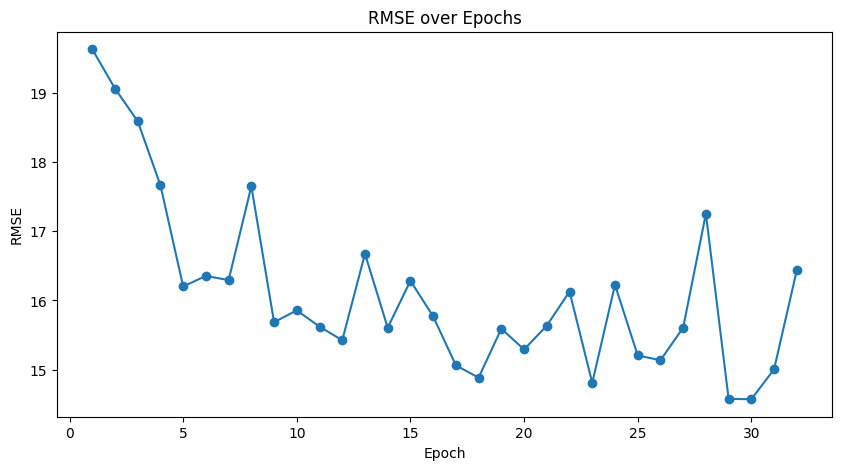

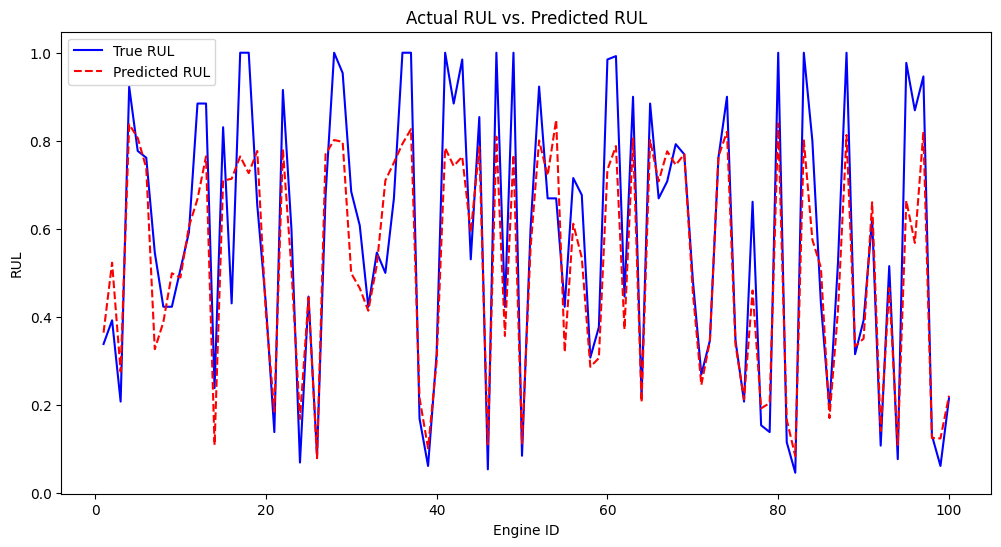

---Iteration: 2---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.17144787952303886
batch:100/219, loss(avg. on 50 batches: 0.03984027680009603
batch:150/219, loss(avg. on 50 batches: 0.03260867763310671
batch:200/219, loss(avg. on 50 batches: 0.02938372552394867
test result: score: 1346.83642578125, RMSE: 21.651273727416992
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.026995324529707432
batch:100/219, loss(avg. on 50 batches: 0.025274175927042963
batch:150/219, loss(avg. on 50 batches: 0.025266740843653678
batch:200/219, loss(avg. on 50 batches: 0.02407764710485935
test result: score: 1168.654296875, RMSE: 21.038986206054688
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.023127733282744884
batch:100/219, loss(avg. on 50 batches: 0.021861710362136366
batch:150/219, loss(avg. on 50 batches: 0.020751393400132656
batch:200/219, loss(avg. on 50 batches: 0.019657026566565036
test result: score: 9

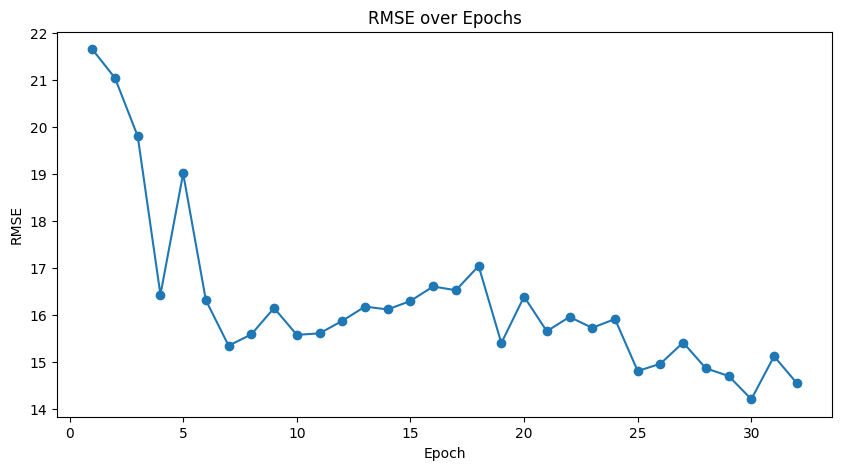

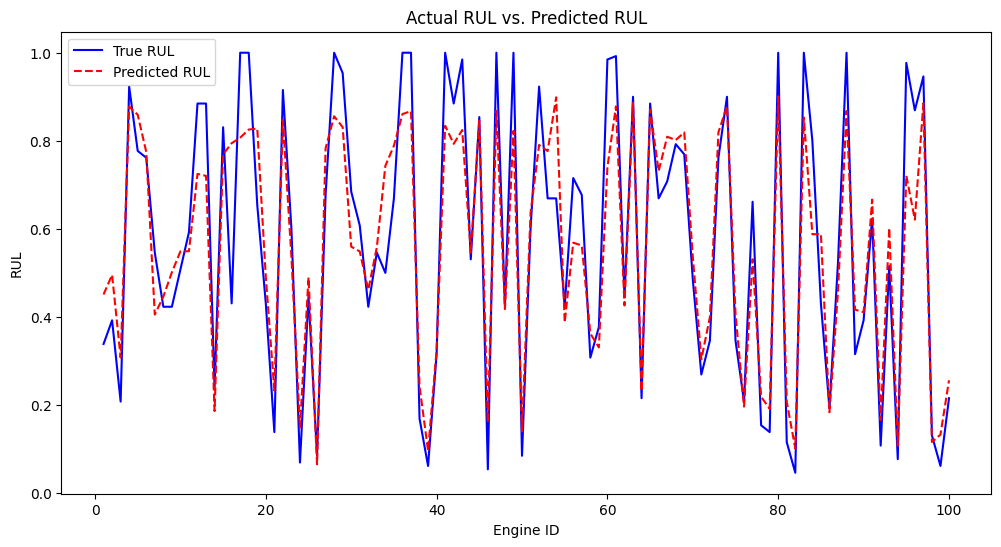

---Iteration: 3---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.1998863374441862
batch:100/219, loss(avg. on 50 batches: 0.044933828860521316
batch:150/219, loss(avg. on 50 batches: 0.03543216947466135
batch:200/219, loss(avg. on 50 batches: 0.03342255886644125
test result: score: 1392.422607421875, RMSE: 21.81085777282715
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.027168072536587717
batch:100/219, loss(avg. on 50 batches: 0.02646427258849144
batch:150/219, loss(avg. on 50 batches: 0.024987121969461443
batch:200/219, loss(avg. on 50 batches: 0.024408495612442495
test result: score: 631.5263671875, RMSE: 17.39031219482422
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.02253632828593254
batch:100/219, loss(avg. on 50 batches: 0.02194374917075038
batch:150/219, loss(avg. on 50 batches: 0.020349268931895495
batch:200/219, loss(avg. on 50 batches: 0.020497676096856595
test result: score: 690.

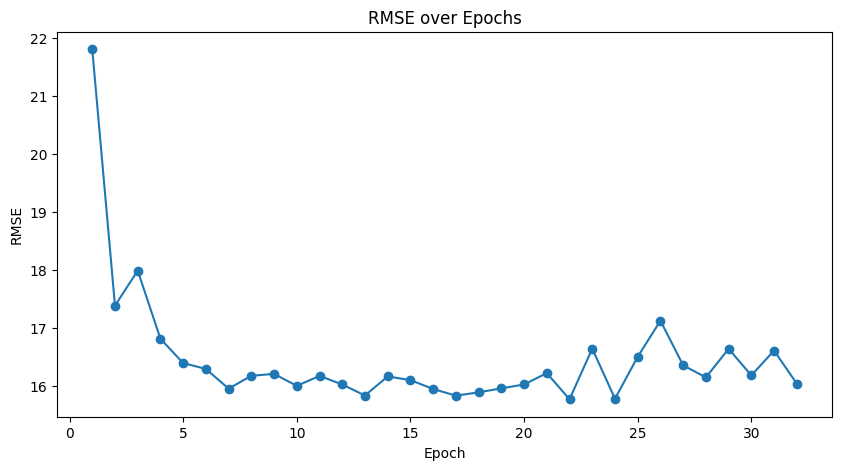

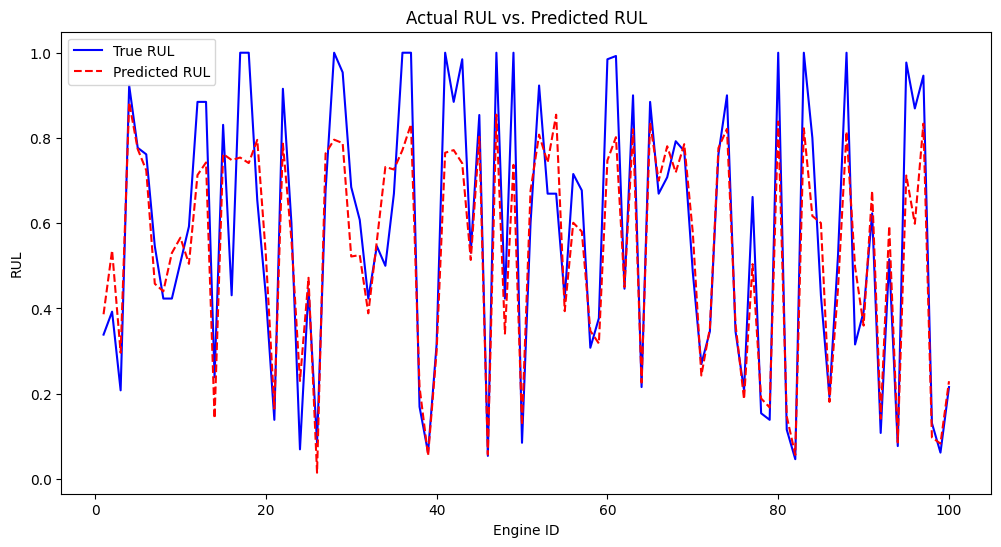

---Iteration: 4---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.1970716727524996
batch:100/219, loss(avg. on 50 batches: 0.04539287194609642
batch:150/219, loss(avg. on 50 batches: 0.034794235564768315
batch:200/219, loss(avg. on 50 batches: 0.03149363402277231
test result: score: 824.5385131835938, RMSE: 18.98711585998535
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.028937397450208666
batch:100/219, loss(avg. on 50 batches: 0.026533033438026904
batch:150/219, loss(avg. on 50 batches: 0.02485860627144575
batch:200/219, loss(avg. on 50 batches: 0.02552634760737419
test result: score: 768.3590087890625, RMSE: 18.90057373046875
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.022951873261481525
batch:100/219, loss(avg. on 50 batches: 0.022385272420942782
batch:150/219, loss(avg. on 50 batches: 0.022384578734636305
batch:200/219, loss(avg. on 50 batches: 0.021640895549207926
test result: score: 

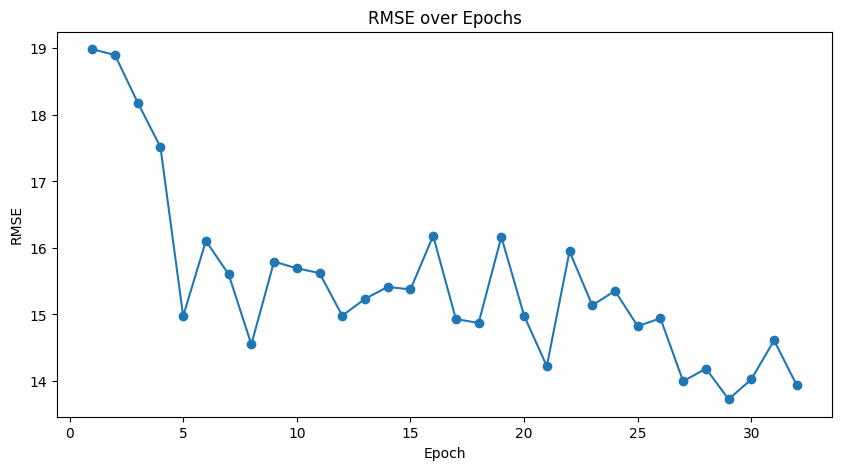

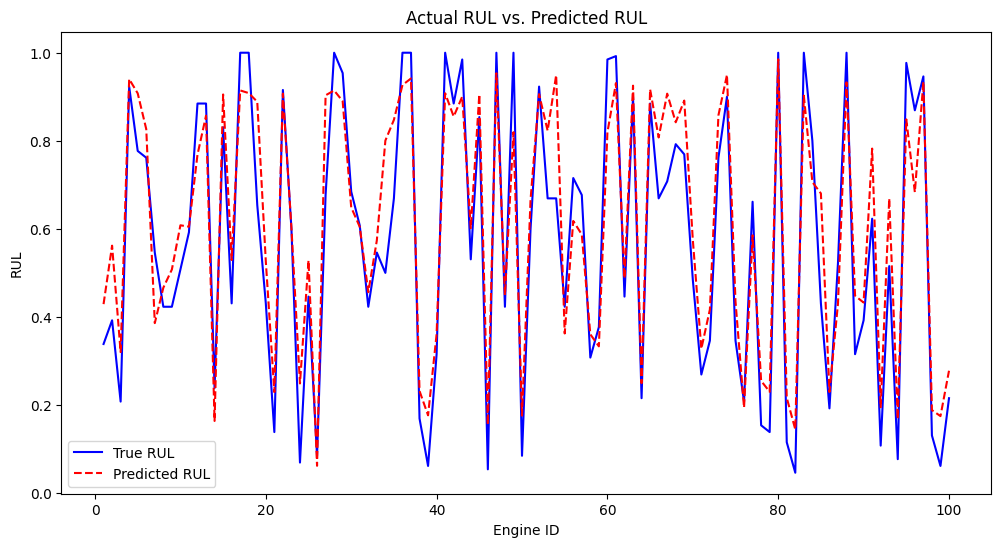

---Iteration: 5---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.189144232198596
batch:100/219, loss(avg. on 50 batches: 0.047424680553376675
batch:150/219, loss(avg. on 50 batches: 0.036407289206981656
batch:200/219, loss(avg. on 50 batches: 0.03237672124058008
test result: score: 635.84716796875, RMSE: 18.121234893798828
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.027935713827610016
batch:100/219, loss(avg. on 50 batches: 0.027244227975606918
batch:150/219, loss(avg. on 50 batches: 0.026544527262449265
batch:200/219, loss(avg. on 50 batches: 0.02515298254787922
test result: score: 783.5609130859375, RMSE: 19.016447067260742
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.023289040364325046
batch:100/219, loss(avg. on 50 batches: 0.022314796075224876
batch:150/219, loss(avg. on 50 batches: 0.022604305520653723
batch:200/219, loss(avg. on 50 batches: 0.021102994568645953
test result: score: 596.9860229492188, RMSE: 17.234949111938477
best_score_checkpoints saved successfull

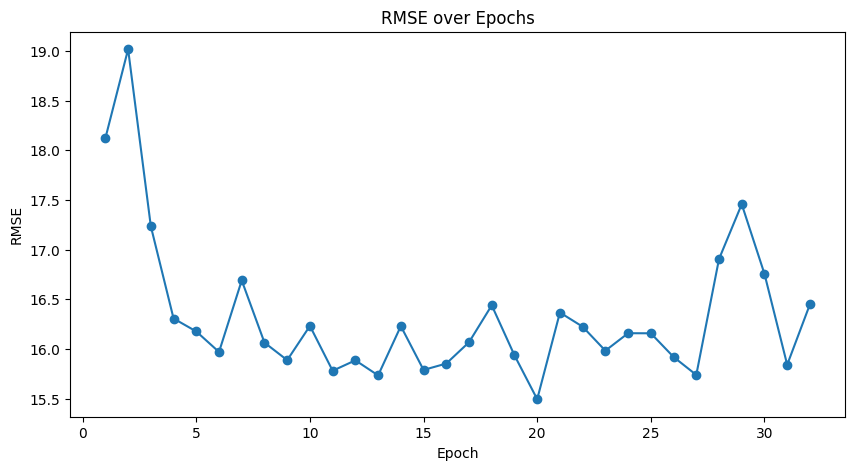

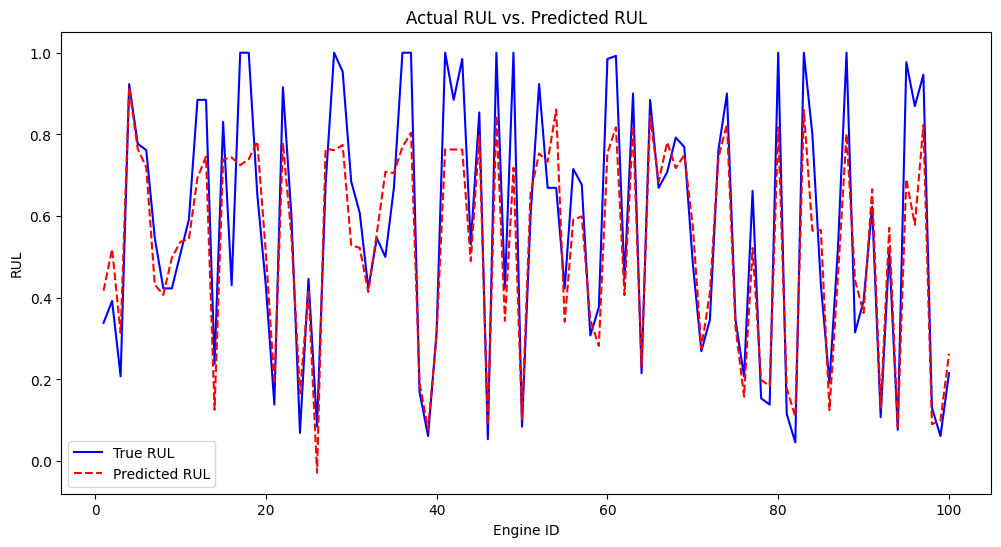

---Iteration: 6---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.2519503954052925
batch:100/219, loss(avg. on 50 batches: 0.055947924554347994
batch:150/219, loss(avg. on 50 batches: 0.04349366214126348
batch:200/219, loss(avg. on 50 batches: 0.03814723607152701
test result: score: 929.6298828125, RMSE: 19.649356842041016
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.03248984161764383
batch:100/219, loss(avg. on 50 batches: 0.030204189009964466
batch:150/219, loss(avg. on 50 batches: 0.02814257688820362
batch:200/219, loss(avg. on 50 batches: 0.026630338542163373
test result: score: 531.7483520507812, RMSE: 16.48044204711914
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.024490580074489118
batch:100/219, loss(avg. on 50 batches: 0.02487464915961027
batch:150/219, loss(avg. on 50 batches: 0.023313041478395462
batch:200/219, loss(avg. on 50 batches: 0.022981707118451596
test result: score: 317

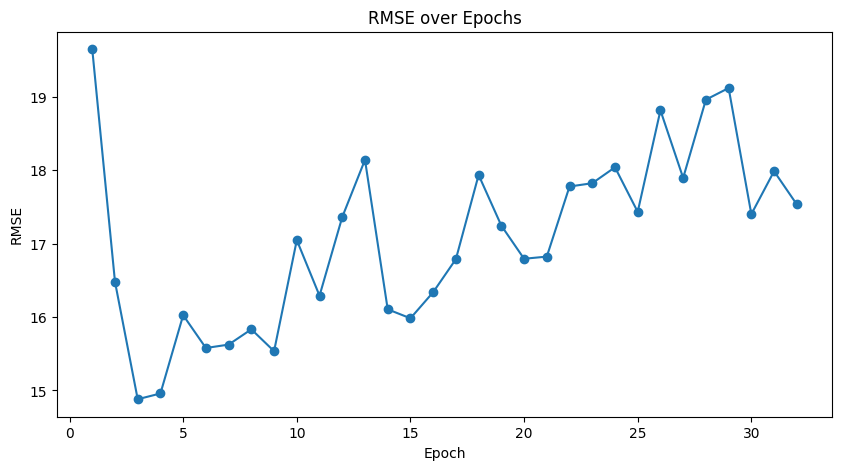

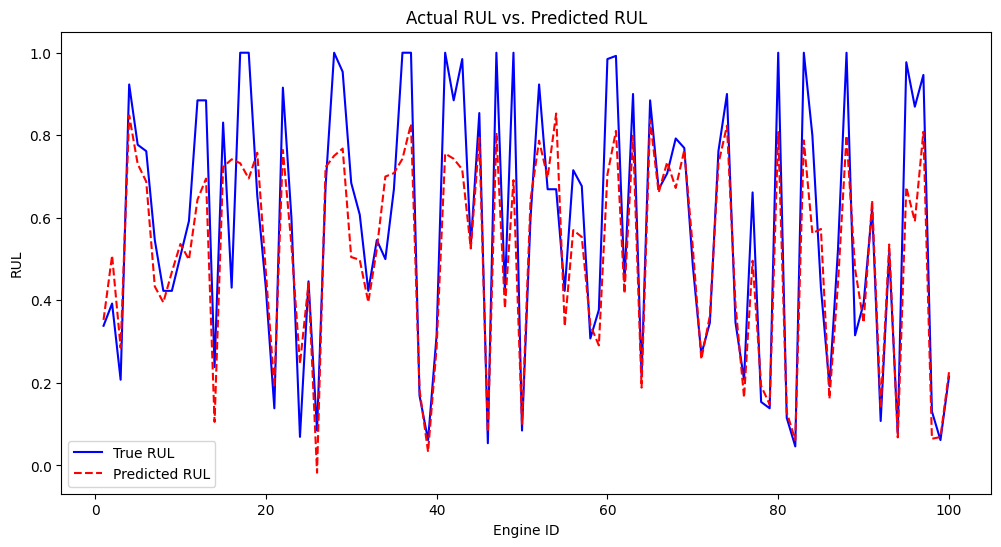

---Iteration: 7---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.37866048499941823
batch:100/219, loss(avg. on 50 batches: 0.051676535308361055
batch:150/219, loss(avg. on 50 batches: 0.03783830355852842
batch:200/219, loss(avg. on 50 batches: 0.03462272867560387
test result: score: 1168.9417724609375, RMSE: 20.278982162475586
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.0301201793551445
batch:100/219, loss(avg. on 50 batches: 0.028225957974791528
batch:150/219, loss(avg. on 50 batches: 0.025517333410680295
batch:200/219, loss(avg. on 50 batches: 0.025774542950093748
test result: score: 561.3558349609375, RMSE: 16.34221839904785
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.024203606024384497
batch:100/219, loss(avg. on 50 batches: 0.023552429378032685
batch:150/219, loss(avg. on 50 batches: 0.02360356330871582
batch:200/219, loss(avg. on 50 batches: 0.022750548981130124
test result: score

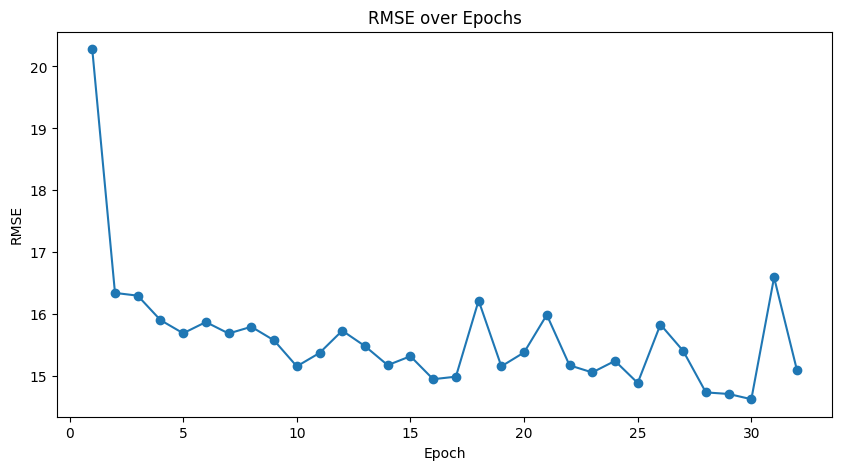

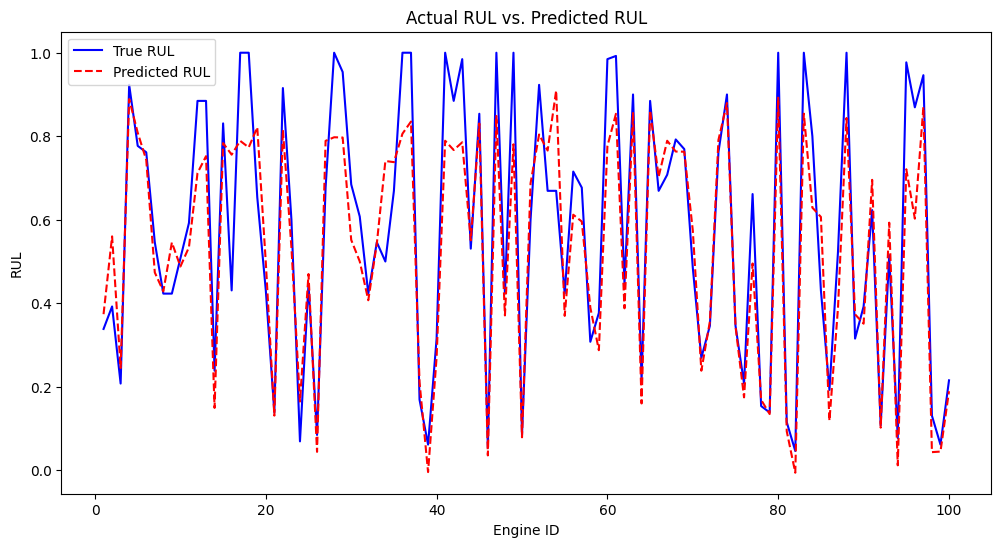

---Iteration: 8---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.21620147094130515
batch:100/219, loss(avg. on 50 batches: 0.047041489332914355
batch:150/219, loss(avg. on 50 batches: 0.038429418168962004
batch:200/219, loss(avg. on 50 batches: 0.03494698010385036
test result: score: 1024.3447265625, RMSE: 20.144567489624023
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.031848743222653866
batch:100/219, loss(avg. on 50 batches: 0.030608168430626394
batch:150/219, loss(avg. on 50 batches: 0.028295627497136593
batch:200/219, loss(avg. on 50 batches: 0.028496253341436385
test result: score: 866.7373046875, RMSE: 19.337648391723633
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.027075767777860166
batch:100/219, loss(avg. on 50 batches: 0.02628505226224661
batch:150/219, loss(avg. on 50 batches: 0.026348390355706214
batch:200/219, loss(avg. on 50 batches: 0.02341312412172556
test result: score: 8

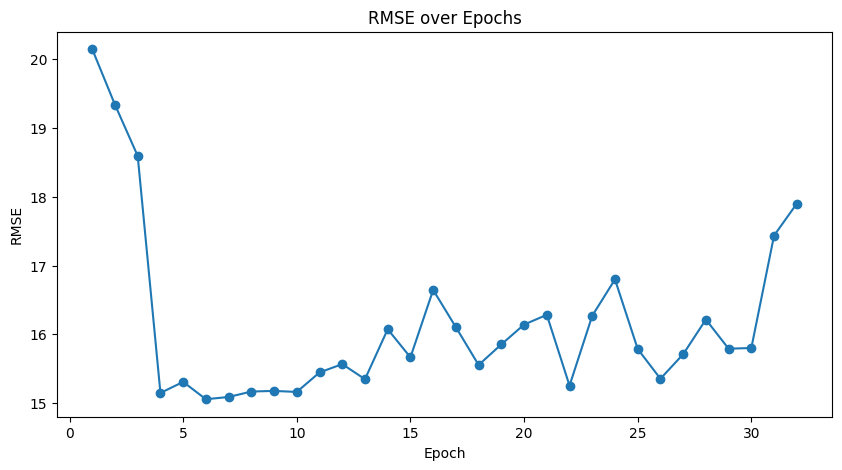

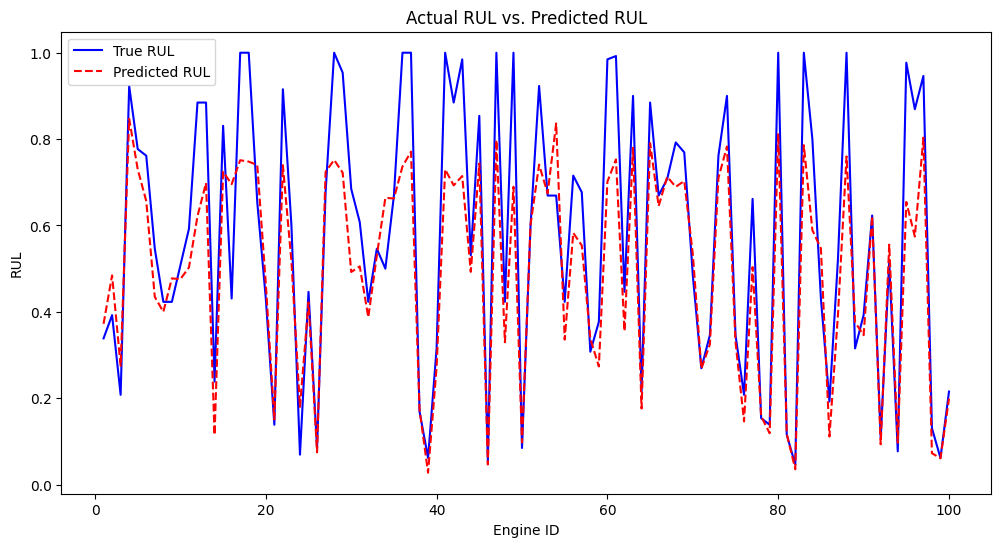

---Iteration: 9---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.27355649262666704
batch:100/219, loss(avg. on 50 batches: 0.050778066143393516
batch:150/219, loss(avg. on 50 batches: 0.035858336687088016
batch:200/219, loss(avg. on 50 batches: 0.031251112930476665
test result: score: 660.7650146484375, RMSE: 17.9136905670166
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.02783141952008009
batch:100/219, loss(avg. on 50 batches: 0.026331863030791283
batch:150/219, loss(avg. on 50 batches: 0.02629749745130539
batch:200/219, loss(avg. on 50 batches: 0.024890978671610355
test result: score: 618.1665649414062, RMSE: 16.968278884887695
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.0235476453974843
batch:100/219, loss(avg. on 50 batches: 0.023528020419180392
batch:150/219, loss(avg. on 50 batches: 0.02307894725352526
batch:200/219, loss(avg. on 50 batches: 0.022685963809490204
test result: score: 

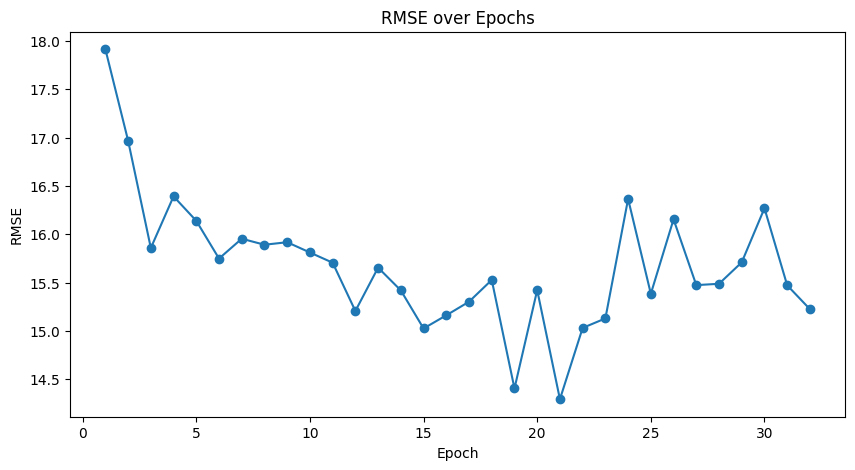

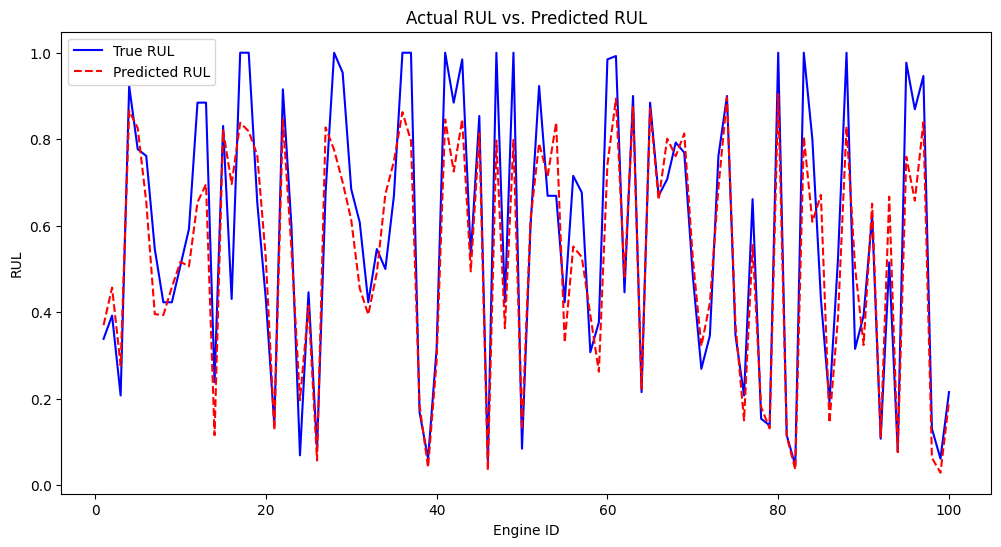

---Iteration: 10---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.46060336247086525
batch:100/219, loss(avg. on 50 batches: 0.051041783019900325
batch:150/219, loss(avg. on 50 batches: 0.040529493503272535
batch:200/219, loss(avg. on 50 batches: 0.03797387558966875
test result: score: 1425.45263671875, RMSE: 22.426719665527344
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.034714140146970746
batch:100/219, loss(avg. on 50 batches: 0.03283163618296385
batch:150/219, loss(avg. on 50 batches: 0.03224056150764227
batch:200/219, loss(avg. on 50 batches: 0.030456763580441474
test result: score: 1225.447265625, RMSE: 21.276256561279297
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.029854985140264034
batch:100/219, loss(avg. on 50 batches: 0.0281180290132761
batch:150/219, loss(avg. on 50 batches: 0.026873043216764928
batch:200/219, loss(avg. on 50 batches: 0.02586148299276829
test result: score: 71

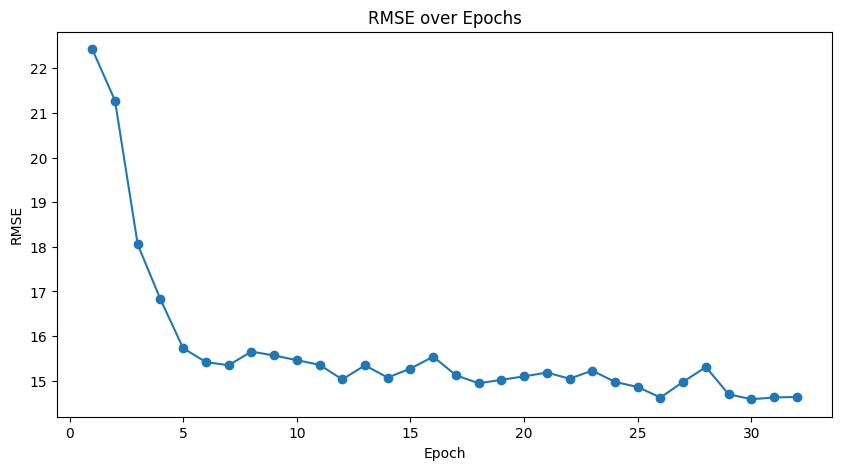

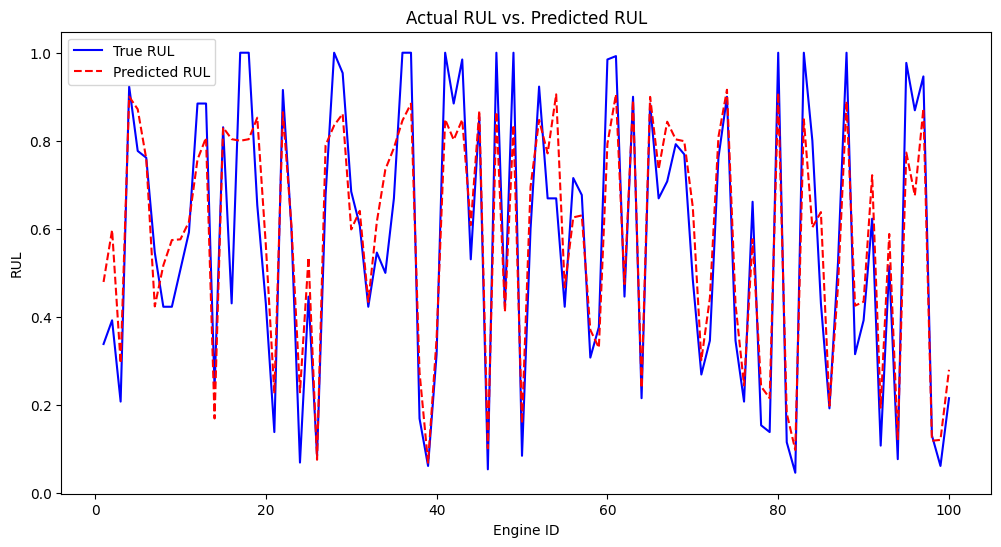

---Iteration: 11---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.38413685977458956
batch:100/219, loss(avg. on 50 batches: 0.06279640816152096
batch:150/219, loss(avg. on 50 batches: 0.05167983211576939
batch:200/219, loss(avg. on 50 batches: 0.046815425120294095
test result: score: 1150.94287109375, RMSE: 20.900426864624023
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.038107201382517816
batch:100/219, loss(avg. on 50 batches: 0.034887973219156265
batch:150/219, loss(avg. on 50 batches: 0.034038019515573975
batch:200/219, loss(avg. on 50 batches: 0.03321203861385584
test result: score: 1074.9000244140625, RMSE: 20.52476692199707
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.030620964206755162
batch:100/219, loss(avg. on 50 batches: 0.029662747234106064
batch:150/219, loss(avg. on 50 batches: 0.028971102945506574
batch:200/219, loss(avg. on 50 batches: 0.027260080575942994
test result: sco

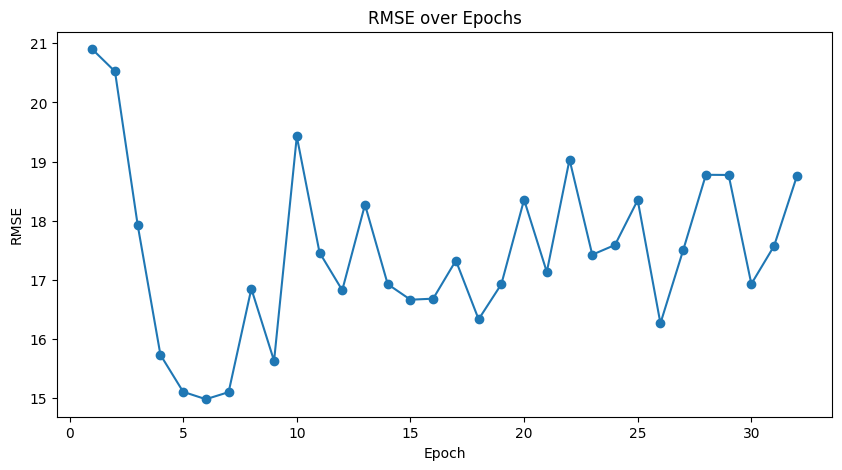

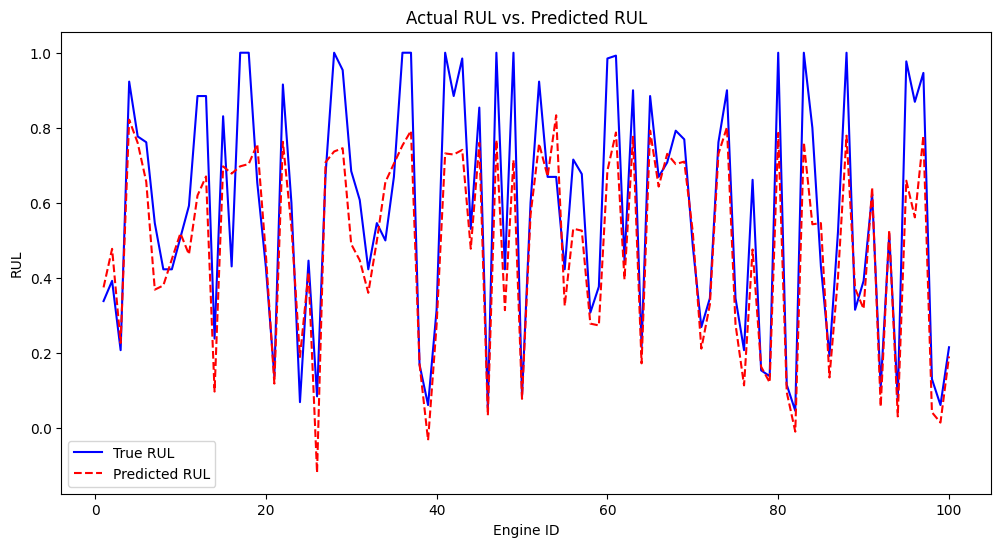

---Iteration: 12---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.3073392026126385
batch:100/219, loss(avg. on 50 batches: 0.052298184931278226
batch:150/219, loss(avg. on 50 batches: 0.04068510979413986
batch:200/219, loss(avg. on 50 batches: 0.035334495380520824
test result: score: 818.1046142578125, RMSE: 18.53953742980957
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.030912421420216562
batch:100/219, loss(avg. on 50 batches: 0.02806532844901085
batch:150/219, loss(avg. on 50 batches: 0.025981548577547073
batch:200/219, loss(avg. on 50 batches: 0.026036218404769898
test result: score: 554.3799438476562, RMSE: 16.630538940429688
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.02474782720208168
batch:100/219, loss(avg. on 50 batches: 0.024661945439875127
batch:150/219, loss(avg. on 50 batches: 0.02366049688309431
batch:200/219, loss(avg. on 50 batches: 0.022816482931375504
test result: score

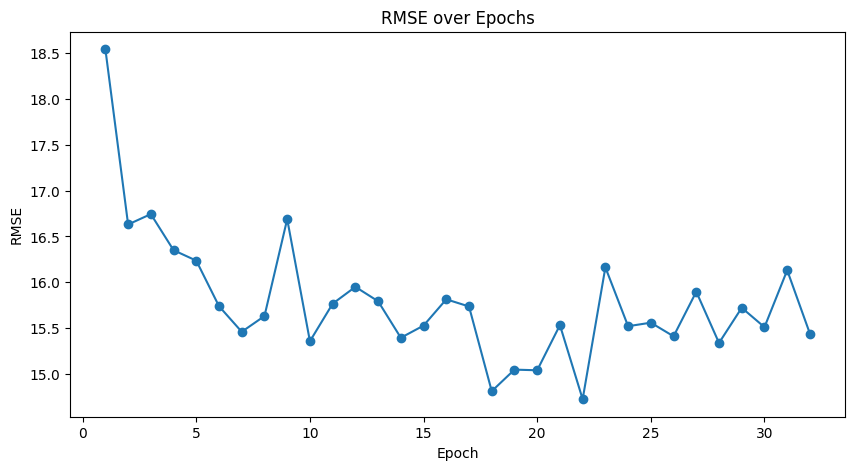

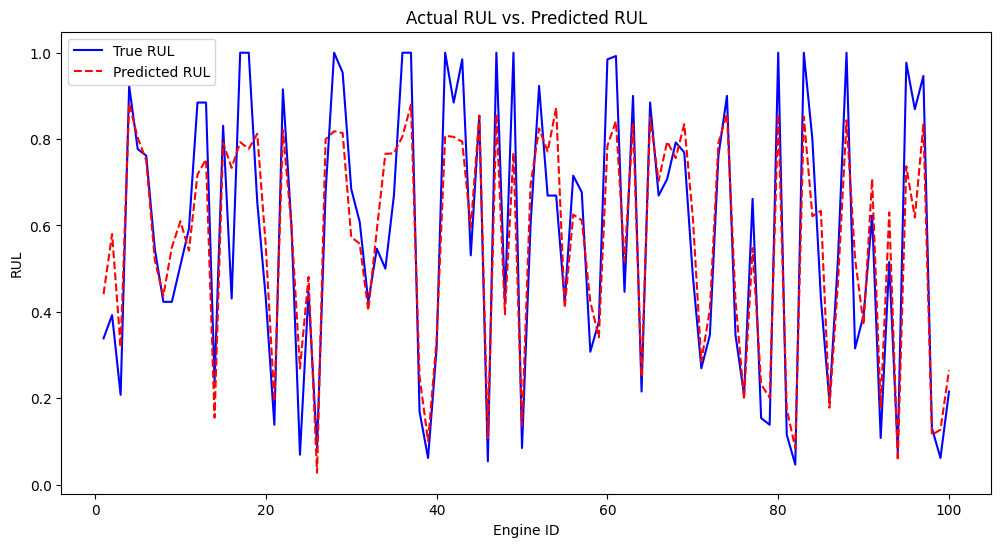

---Iteration: 13---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.4139238552749157
batch:100/219, loss(avg. on 50 batches: 0.05873106427490711
batch:150/219, loss(avg. on 50 batches: 0.04708372000604868
batch:200/219, loss(avg. on 50 batches: 0.04251692473888397
test result: score: 1246.343017578125, RMSE: 22.03514289855957
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.03944638002663851
batch:100/219, loss(avg. on 50 batches: 0.033756252974271775
batch:150/219, loss(avg. on 50 batches: 0.030733134895563126
batch:200/219, loss(avg. on 50 batches: 0.02763403154909611
test result: score: 470.296630859375, RMSE: 16.21813201904297
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.025133298859000206
batch:100/219, loss(avg. on 50 batches: 0.02463902149349451
batch:150/219, loss(avg. on 50 batches: 0.024311731420457363
batch:200/219, loss(avg. on 50 batches: 0.023382755294442177
test result: score: 38

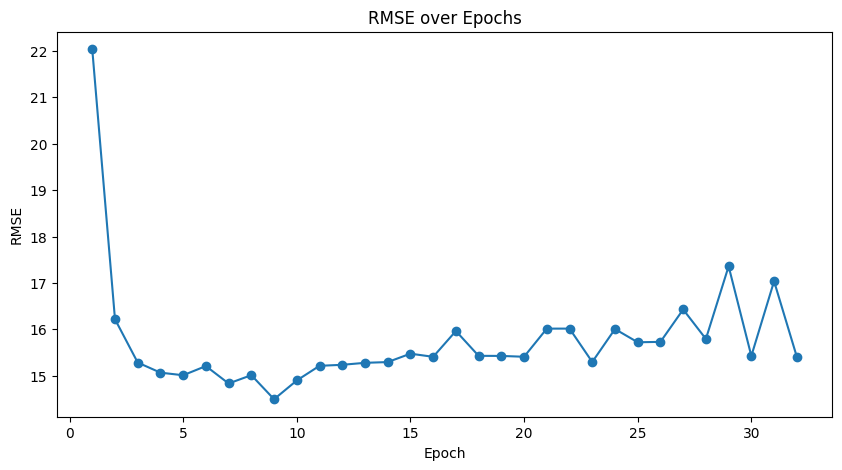

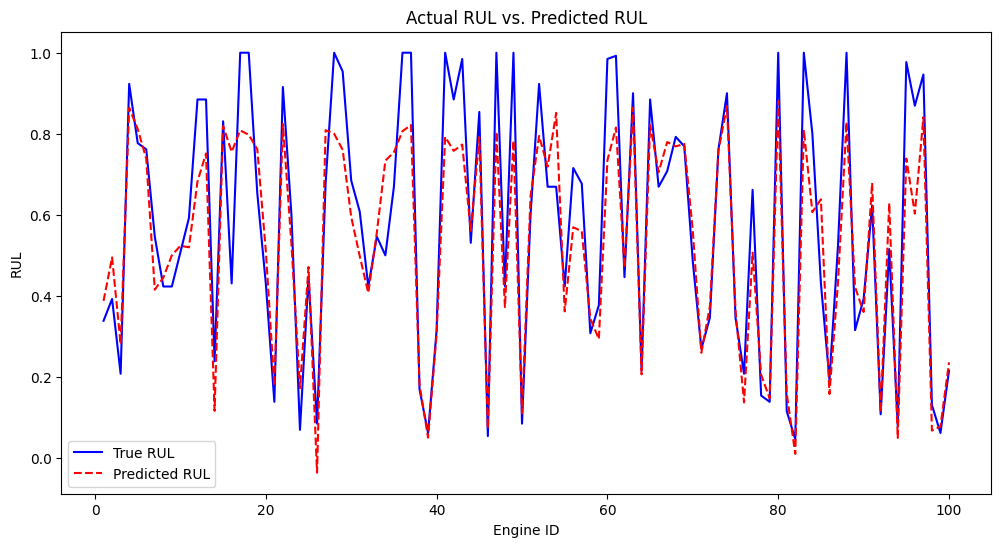

---Iteration: 14---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.17931260384619235
batch:100/219, loss(avg. on 50 batches: 0.06021049655973911
batch:150/219, loss(avg. on 50 batches: 0.04994531363248825
batch:200/219, loss(avg. on 50 batches: 0.042230947650969027
test result: score: 1164.893798828125, RMSE: 21.378313064575195
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.033791238889098164
batch:100/219, loss(avg. on 50 batches: 0.027095688581466673
batch:150/219, loss(avg. on 50 batches: 0.023968995213508607
batch:200/219, loss(avg. on 50 batches: 0.02382361698895693
test result: score: 943.3409423828125, RMSE: 18.5317440032959
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.022085313946008683
batch:100/219, loss(avg. on 50 batches: 0.021770336758345367
batch:150/219, loss(avg. on 50 batches: 0.021116934716701508
batch:200/219, loss(avg. on 50 batches: 0.021330104060471058
test result: scor

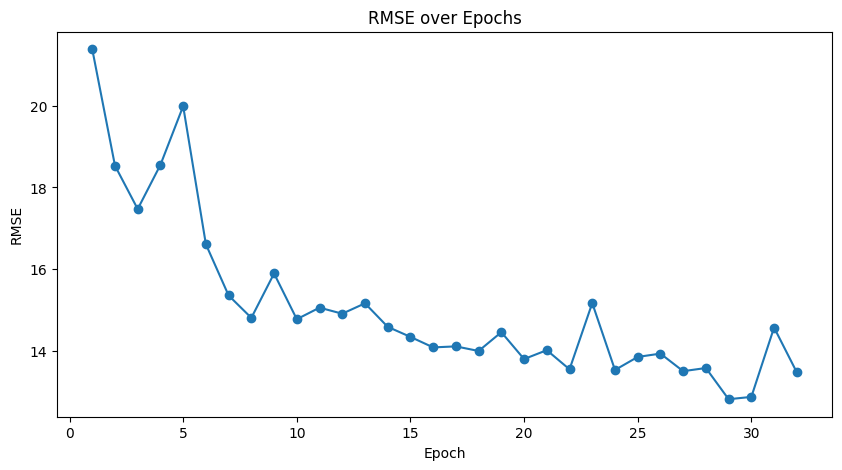

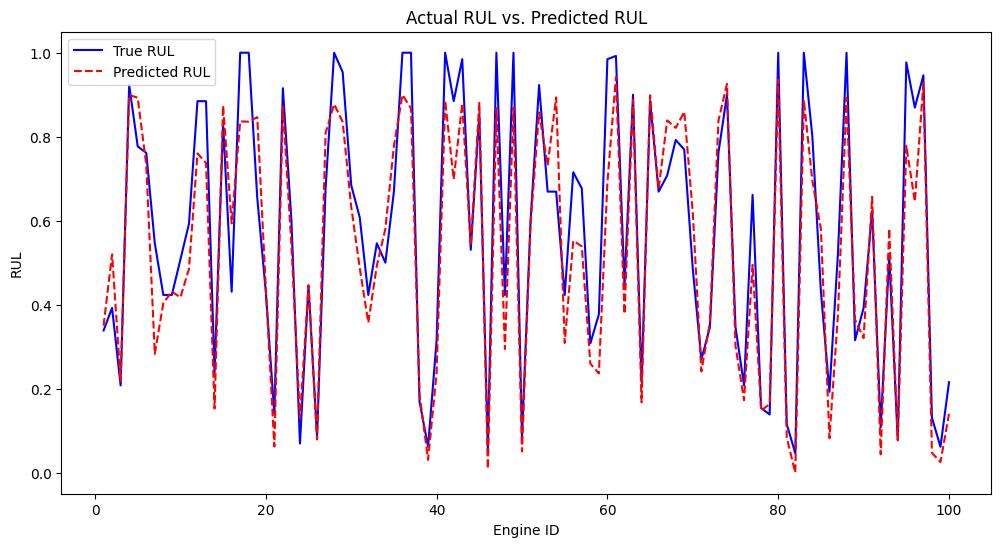

---Iteration: 15---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.27243968717753886
batch:100/219, loss(avg. on 50 batches: 0.048755939044058325
batch:150/219, loss(avg. on 50 batches: 0.040373830199241637
batch:200/219, loss(avg. on 50 batches: 0.0364703869074583
test result: score: 1948.9158935546875, RMSE: 23.71448516845703
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.03167359489947558
batch:100/219, loss(avg. on 50 batches: 0.030283918082714082
batch:150/219, loss(avg. on 50 batches: 0.028531965501606464
batch:200/219, loss(avg. on 50 batches: 0.02688663877546787
test result: score: 1201.4088134765625, RMSE: 20.95222282409668
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.02644279062747955
batch:100/219, loss(avg. on 50 batches: 0.025268927961587907
batch:150/219, loss(avg. on 50 batches: 0.023264053501188754
batch:200/219, loss(avg. on 50 batches: 0.02312126962468028
test result: score

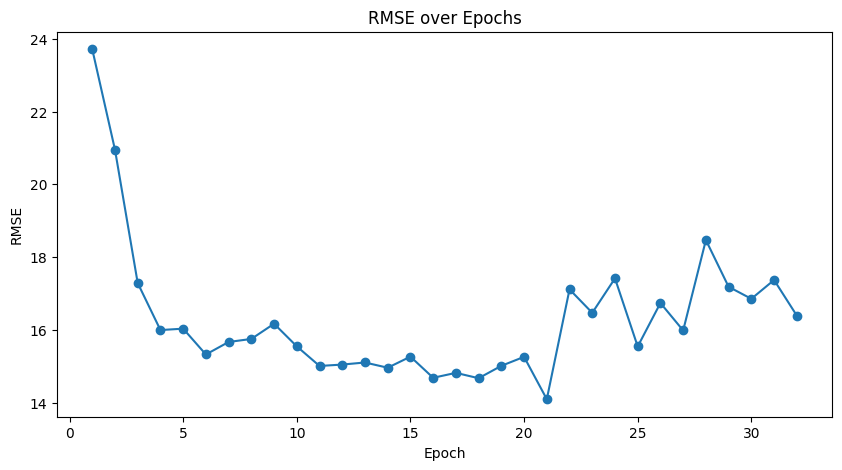

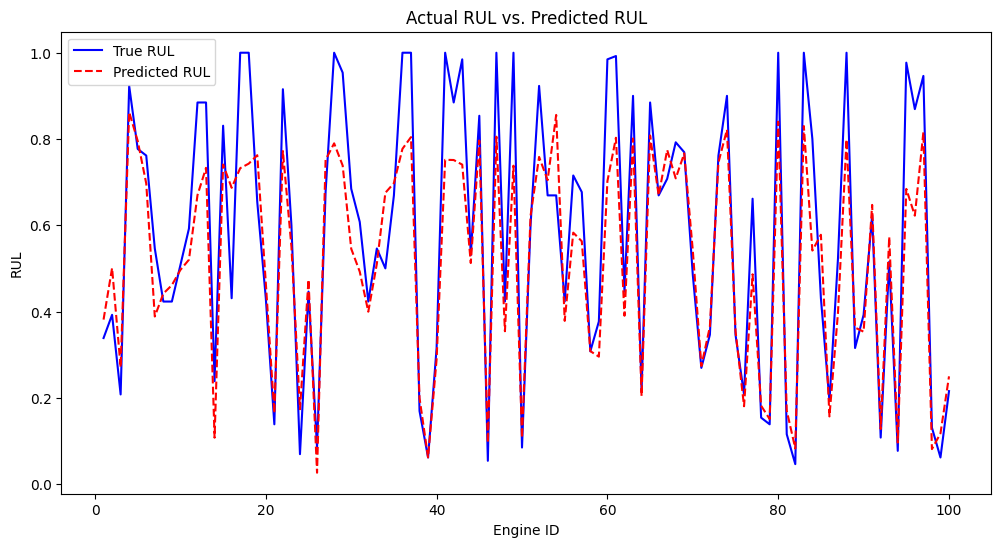

---Iteration: 16---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.23717568188905716
batch:100/219, loss(avg. on 50 batches: 0.04428973577916622
batch:150/219, loss(avg. on 50 batches: 0.03558526523411274
batch:200/219, loss(avg. on 50 batches: 0.03140498675405979
test result: score: 891.4812622070312, RMSE: 19.808792114257812
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.027507087998092174
batch:100/219, loss(avg. on 50 batches: 0.027414866276085376
batch:150/219, loss(avg. on 50 batches: 0.025300148390233517
batch:200/219, loss(avg. on 50 batches: 0.02465476468205452
test result: score: 956.6934204101562, RMSE: 19.610990524291992
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.02304276067763567
batch:100/219, loss(avg. on 50 batches: 0.023417940214276314
batch:150/219, loss(avg. on 50 batches: 0.022133044879883528
batch:200/219, loss(avg. on 50 batches: 0.02261439472436905
test result: score: 830.5103759765625, RMSE: 18.1752185821533

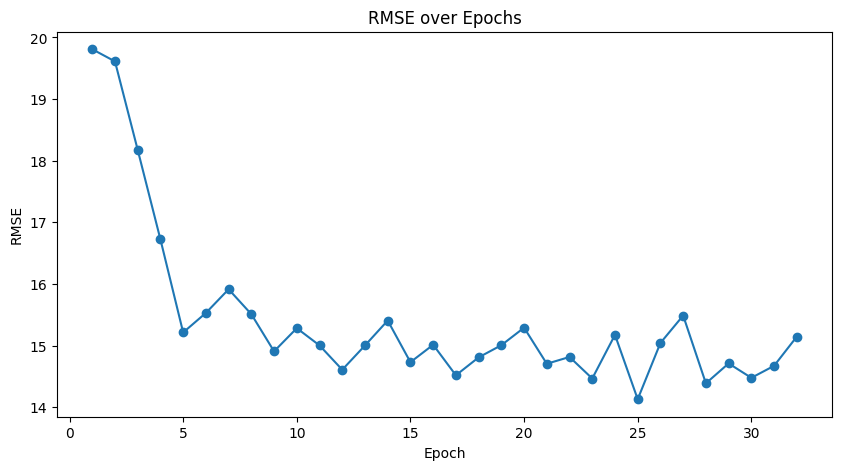

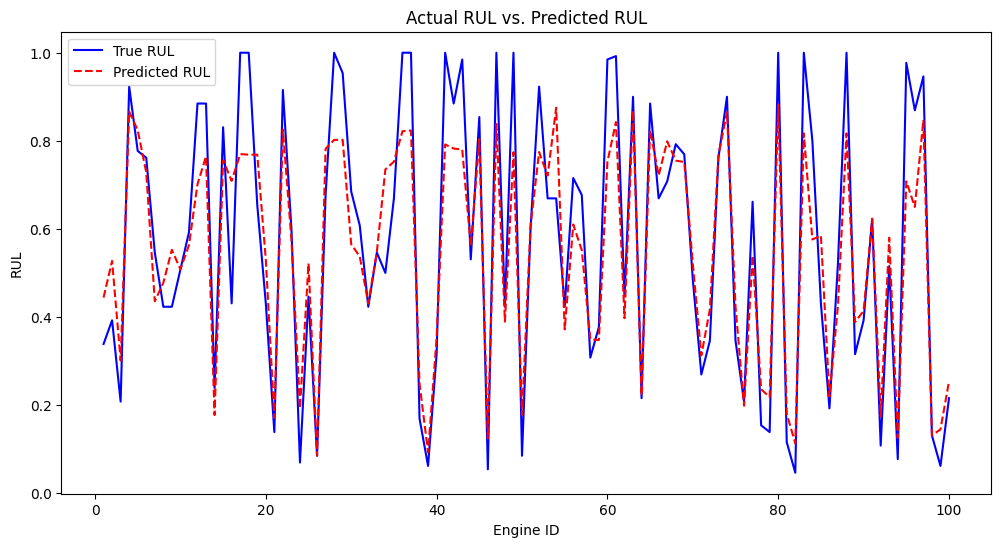

---Iteration: 17---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.3045294538140297
batch:100/219, loss(avg. on 50 batches: 0.04982250139117241
batch:150/219, loss(avg. on 50 batches: 0.04044814445078373
batch:200/219, loss(avg. on 50 batches: 0.03673399575054646
test result: score: 963.470703125, RMSE: 19.48166847229004
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.031861386448144915
batch:100/219, loss(avg. on 50 batches: 0.030659135952591895
batch:150/219, loss(avg. on 50 batches: 0.02875828854739666
batch:200/219, loss(avg. on 50 batches: 0.02657963715493679
test result: score: 479.5316467285156, RMSE: 16.14060401916504
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.026134140230715273
batch:100/219, loss(avg. on 50 batches: 0.025459023490548134
batch:150/219, loss(avg. on 50 batches: 0.02413560274988413
batch:200/219, loss(avg. on 50 batches: 0.023488919995725156
test result: score: 455.2

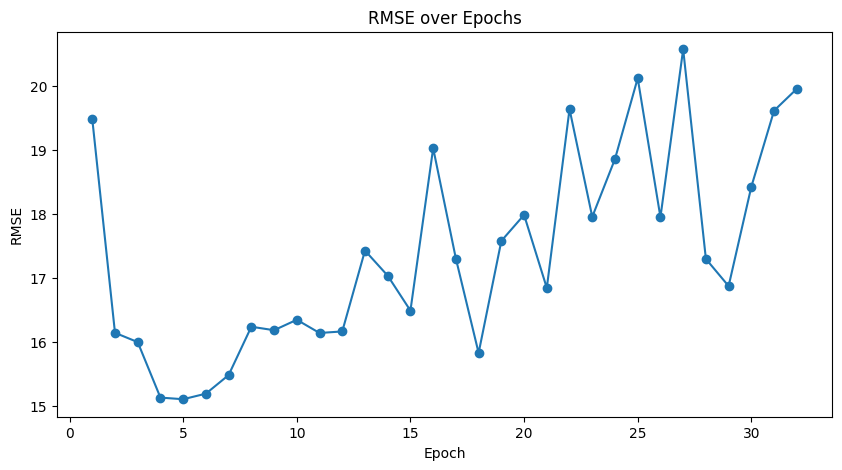

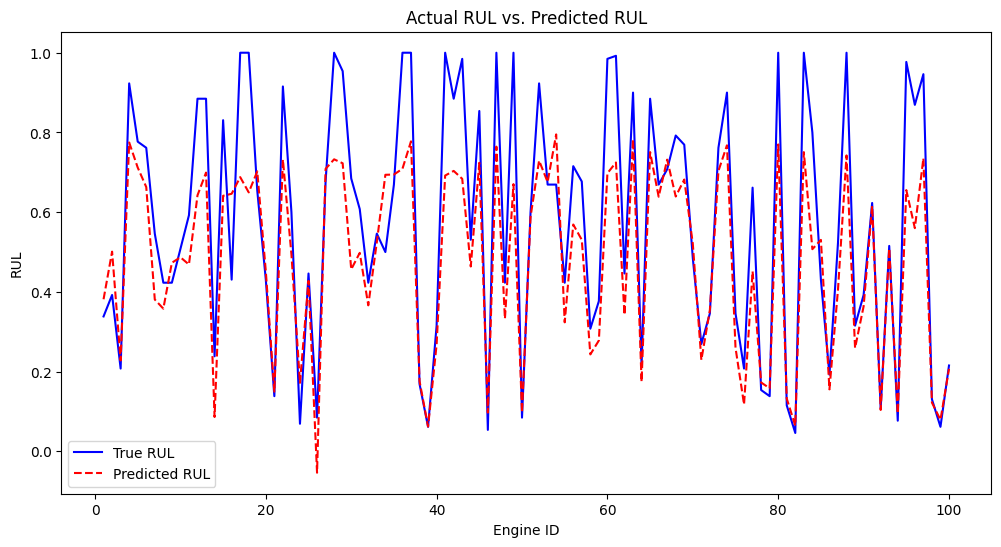

---Iteration: 18---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.1366292794793844
batch:100/219, loss(avg. on 50 batches: 0.03706809524446726
batch:150/219, loss(avg. on 50 batches: 0.030211603008210658
batch:200/219, loss(avg. on 50 batches: 0.02657006248831749
test result: score: 1245.7005615234375, RMSE: 21.63448143005371
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.024479687474668027
batch:100/219, loss(avg. on 50 batches: 0.02372939344495535
batch:150/219, loss(avg. on 50 batches: 0.022884831465780735
batch:200/219, loss(avg. on 50 batches: 0.022567958645522593
test result: score: 1015.7120971679688, RMSE: 20.13580894470215
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.021269423700869084
batch:100/219, loss(avg. on 50 batches: 0.02044914221391082
batch:150/219, loss(avg. on 50 batches: 0.019989656247198583
batch:200/219, loss(avg. on 50 batches: 0.01912112532183528
test result: score

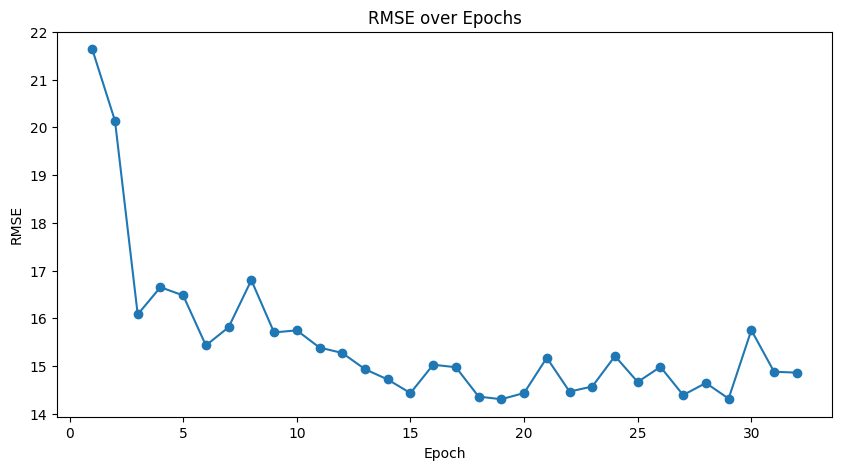

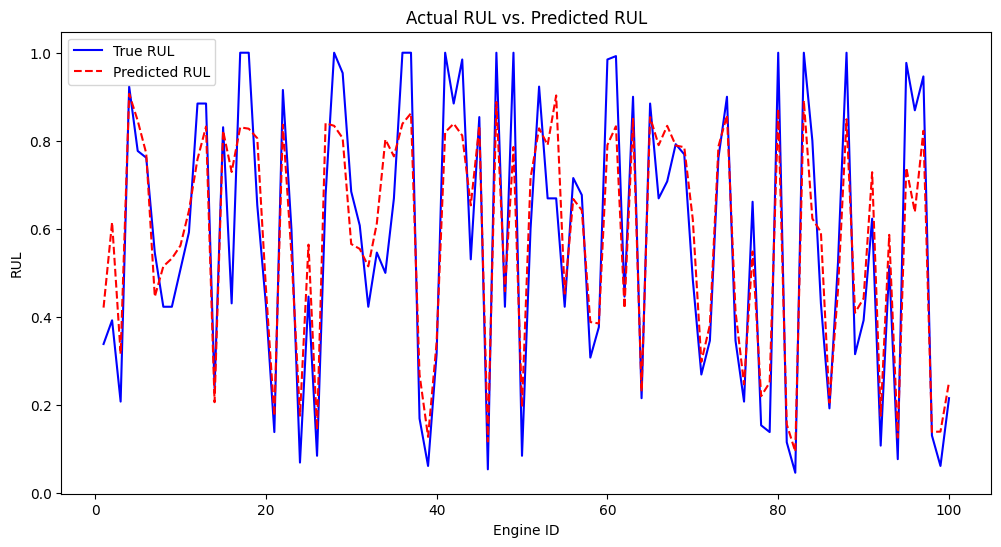

---Iteration: 19---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.12752247616648674
batch:100/219, loss(avg. on 50 batches: 0.042843823358416556
batch:150/219, loss(avg. on 50 batches: 0.03951460301876068
batch:200/219, loss(avg. on 50 batches: 0.03363403894007206
test result: score: 1538.25341796875, RMSE: 22.870649337768555
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.02999486144632101
batch:100/219, loss(avg. on 50 batches: 0.028140197917819024
batch:150/219, loss(avg. on 50 batches: 0.02677972983568907
batch:200/219, loss(avg. on 50 batches: 0.0268348503485322
test result: score: 1081.3804931640625, RMSE: 20.206493377685547
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.02418332740664482
batch:100/219, loss(avg. on 50 batches: 0.02320861991494894
batch:150/219, loss(avg. on 50 batches: 0.022442009206861256
batch:200/219, loss(avg. on 50 batches: 0.02173248864710331
test result: score: 1

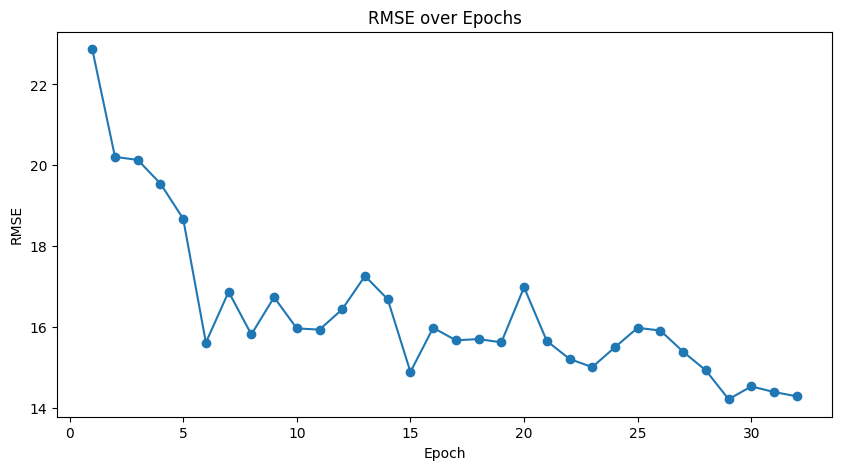

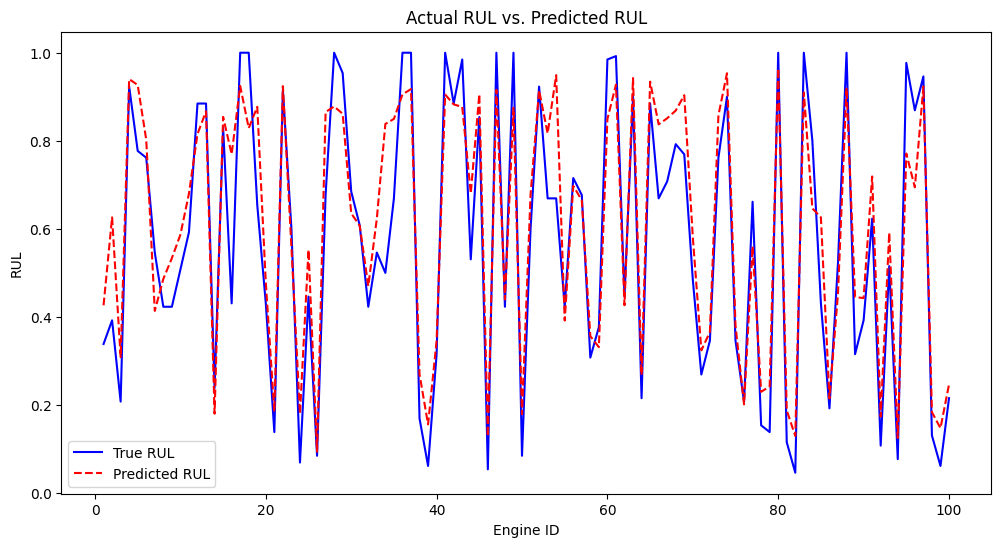

---Iteration: 20---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.3248444209247828
batch:100/219, loss(avg. on 50 batches: 0.05517536625266075
batch:150/219, loss(avg. on 50 batches: 0.0446509313583374
batch:200/219, loss(avg. on 50 batches: 0.038247133903205395
test result: score: 905.4783935546875, RMSE: 20.070825576782227
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.03389164105057716
batch:100/219, loss(avg. on 50 batches: 0.03235908612608909
batch:150/219, loss(avg. on 50 batches: 0.030661444738507272
batch:200/219, loss(avg. on 50 batches: 0.029404112733900548
test result: score: 699.9632568359375, RMSE: 18.016820907592773
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.028672726787626744
batch:100/219, loss(avg. on 50 batches: 0.02601853683590889
batch:150/219, loss(avg. on 50 batches: 0.02538710955530405
batch:200/219, loss(avg. on 50 batches: 0.024732740111649037
test result: score: 

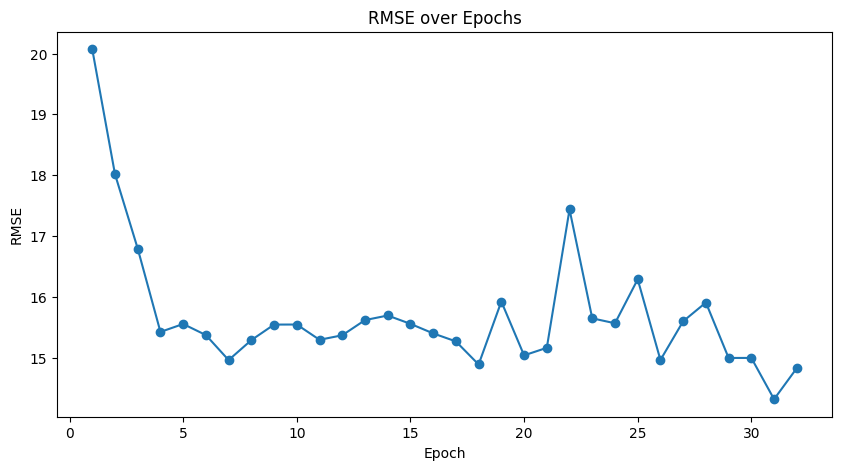

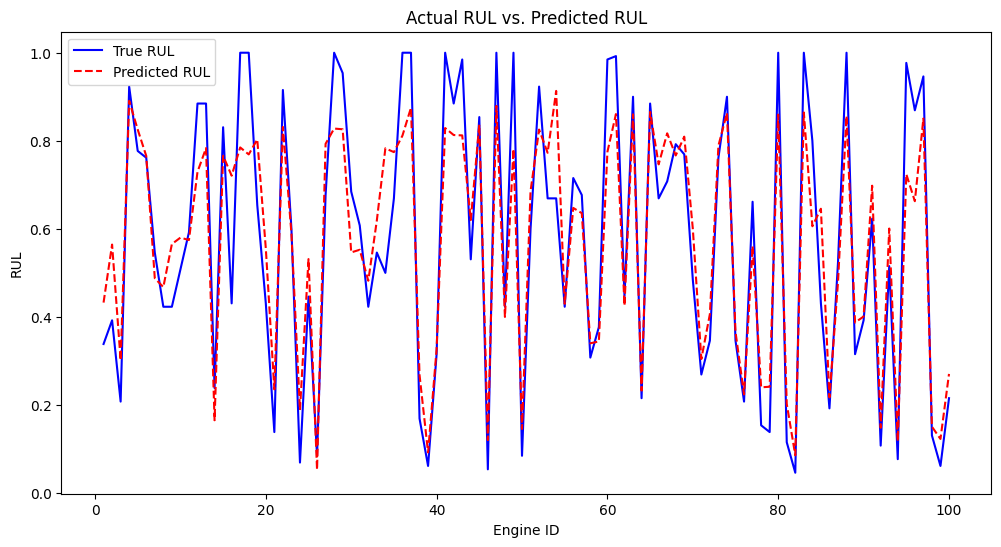

---Iteration: 21---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.14221755519509316
batch:100/219, loss(avg. on 50 batches: 0.039697024673223495
batch:150/219, loss(avg. on 50 batches: 0.030547024682164192
batch:200/219, loss(avg. on 50 batches: 0.027881098687648775
test result: score: 714.0167846679688, RMSE: 18.42987823486328
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.024791988357901574
batch:100/219, loss(avg. on 50 batches: 0.024464436024427414
batch:150/219, loss(avg. on 50 batches: 0.022200649455189705
batch:200/219, loss(avg. on 50 batches: 0.021552839931100607
test result: score: 605.6427001953125, RMSE: 17.22683334350586
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.02044321469962597
batch:100/219, loss(avg. on 50 batches: 0.020834766086190937
batch:150/219, loss(avg. on 50 batches: 0.020359197910875083
batch:200/219, loss(avg. on 50 batches: 0.02076014591380954
test result: sco

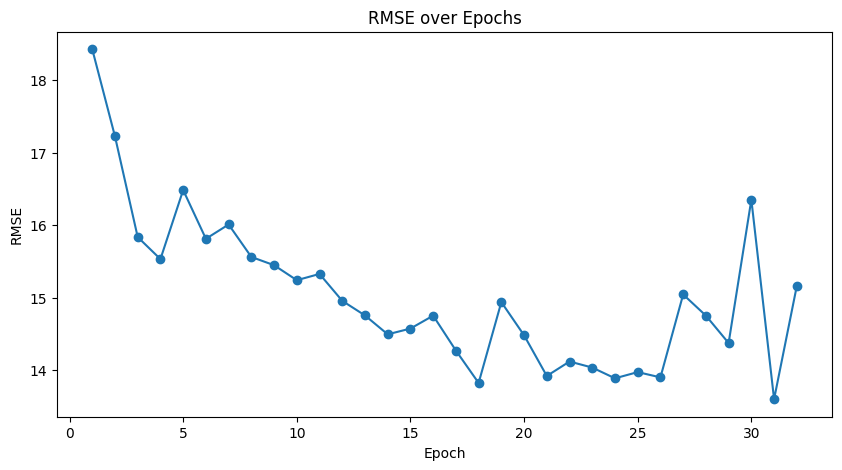

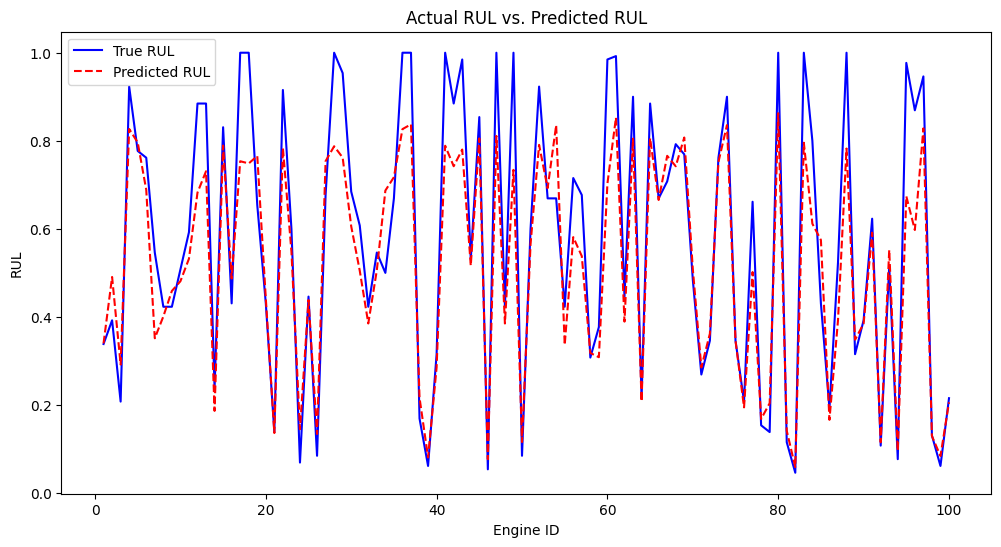

---Iteration: 22---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.259238935187459
batch:100/219, loss(avg. on 50 batches: 0.040797653086483476
batch:150/219, loss(avg. on 50 batches: 0.03528444517403841
batch:200/219, loss(avg. on 50 batches: 0.03222544945776463
test result: score: 1241.0303955078125, RMSE: 21.73663330078125
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.028084884807467462
batch:100/219, loss(avg. on 50 batches: 0.027552608773112296
batch:150/219, loss(avg. on 50 batches: 0.02627791404724121
batch:200/219, loss(avg. on 50 batches: 0.02517090268433094
test result: score: 1143.20751953125, RMSE: 20.79047966003418
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.02353649390861392
batch:100/219, loss(avg. on 50 batches: 0.02356789819896221
batch:150/219, loss(avg. on 50 batches: 0.023559633530676364
batch:200/219, loss(avg. on 50 batches: 0.02222604651004076
test result: score: 785

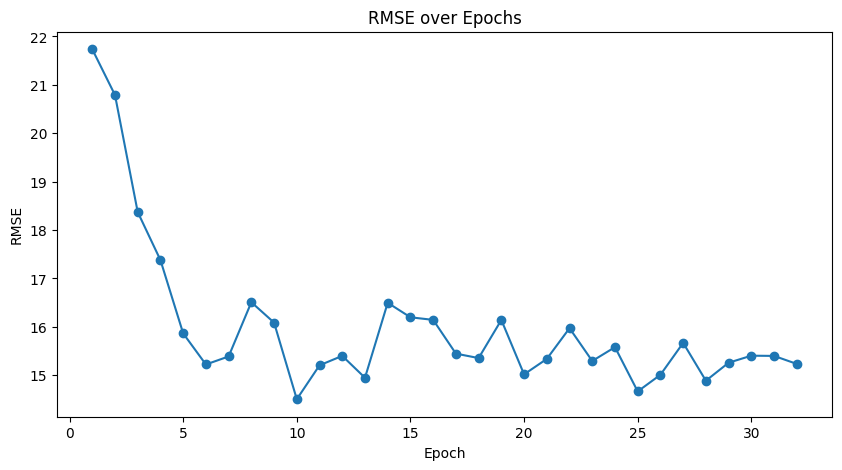

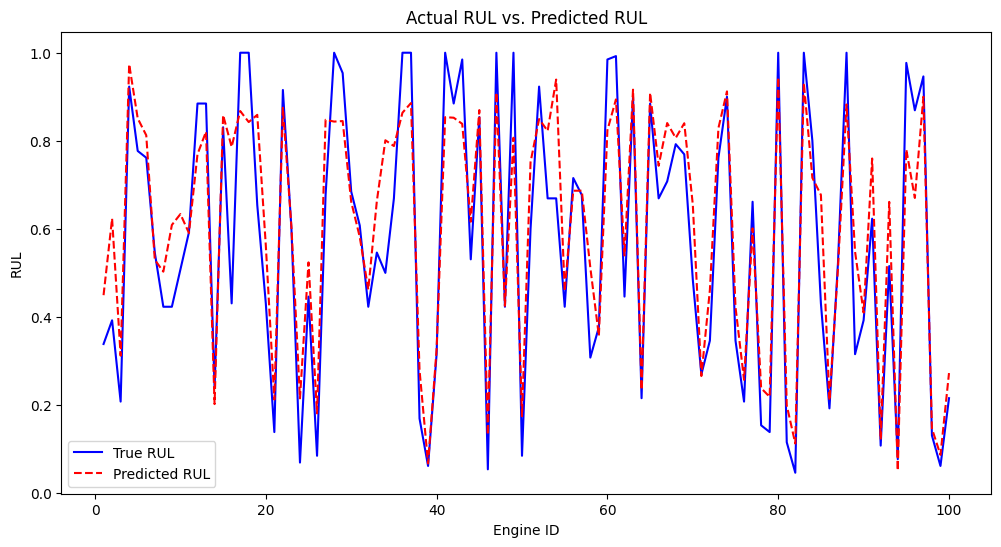

---Iteration: 23---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.19585987642407418
batch:100/219, loss(avg. on 50 batches: 0.04885554328560829
batch:150/219, loss(avg. on 50 batches: 0.03806096151471138
batch:200/219, loss(avg. on 50 batches: 0.03250812489539385
test result: score: 1285.258544921875, RMSE: 21.440269470214844
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.029516633301973343
batch:100/219, loss(avg. on 50 batches: 0.027249606885015966
batch:150/219, loss(avg. on 50 batches: 0.0252607823908329
batch:200/219, loss(avg. on 50 batches: 0.024988089203834534
test result: score: 506.94769287109375, RMSE: 16.536455154418945
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.023594520688056946
batch:100/219, loss(avg. on 50 batches: 0.022360455133020877
batch:150/219, loss(avg. on 50 batches: 0.02178167153149843
batch:200/219, loss(avg. on 50 batches: 0.019861498456448315
test result: scor

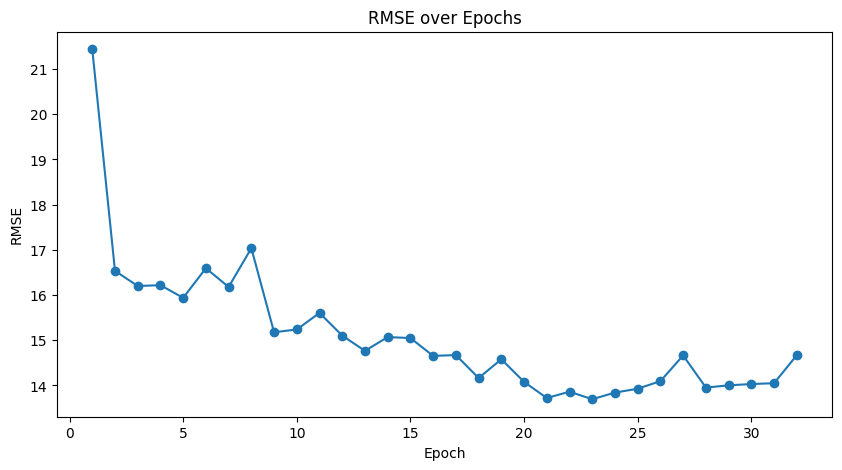

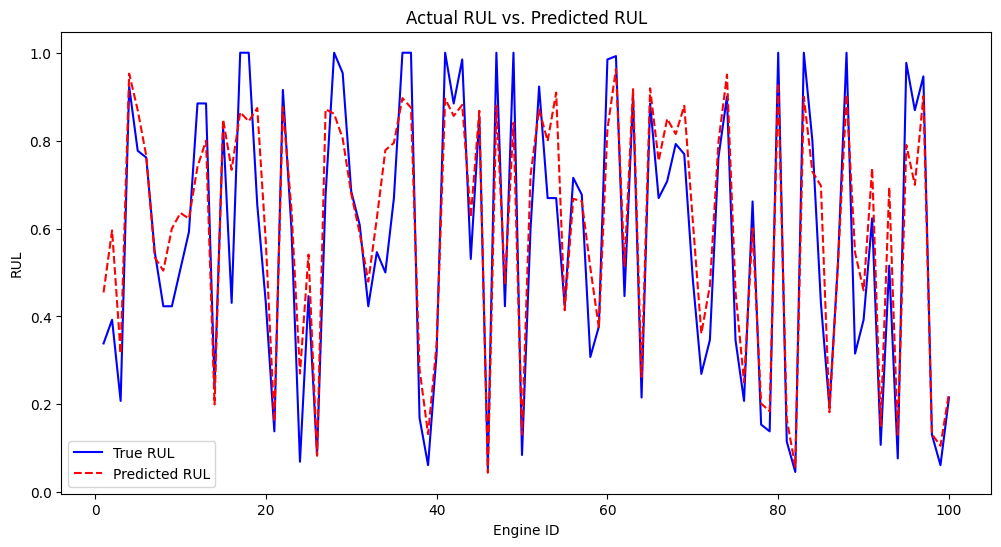

---Iteration: 24---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.16999550230801105
batch:100/219, loss(avg. on 50 batches: 0.043878123909235
batch:150/219, loss(avg. on 50 batches: 0.03474752940237522
batch:200/219, loss(avg. on 50 batches: 0.029227772131562232
test result: score: 975.3933715820312, RMSE: 19.328460693359375
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.025357070080935955
batch:100/219, loss(avg. on 50 batches: 0.024888245724141597
batch:150/219, loss(avg. on 50 batches: 0.022980734184384347
batch:200/219, loss(avg. on 50 batches: 0.020952828265726565
test result: score: 501.0625, RMSE: 16.46895980834961
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.02074535220861435
batch:100/219, loss(avg. on 50 batches: 0.018449041023850442
batch:150/219, loss(avg. on 50 batches: 0.01793119041249156
batch:200/219, loss(avg. on 50 batches: 0.01705601703375578
test result: score: 587.27716

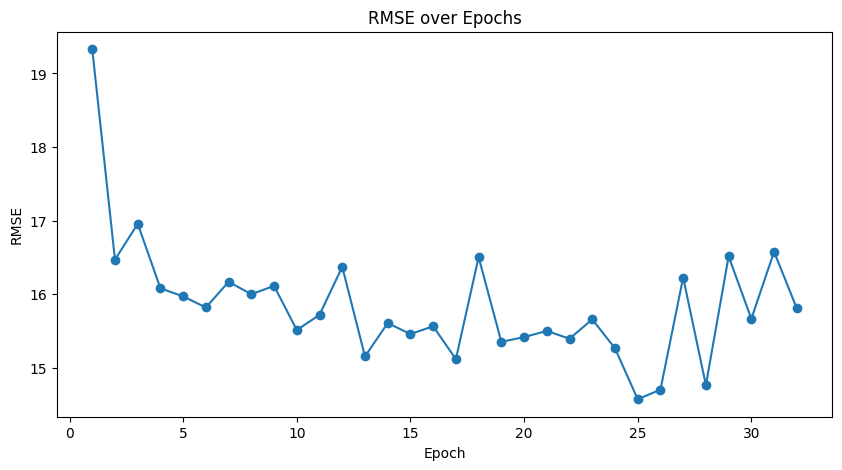

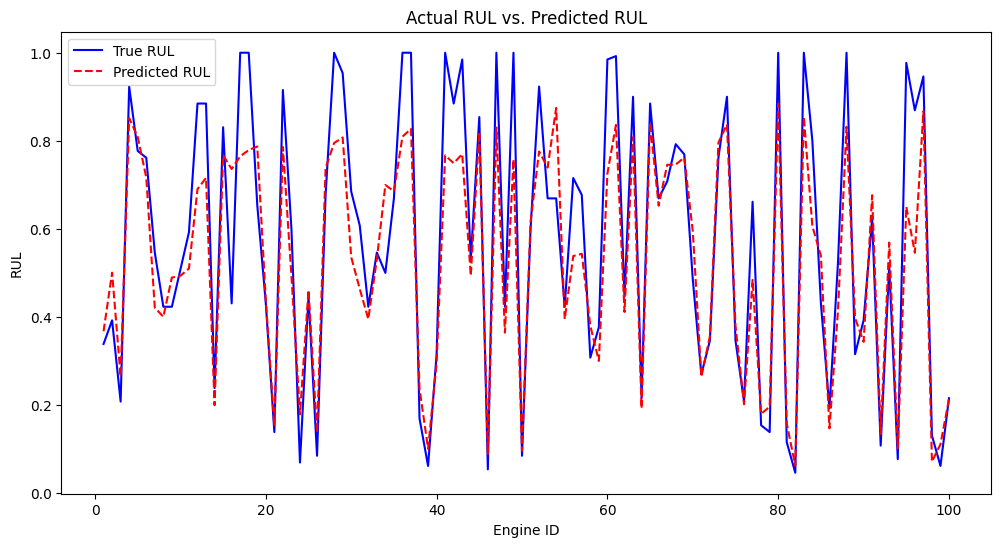

---Iteration: 25---
Epoch: 1
batch:50/219, loss(avg. on 50 batches: 0.2285408952087164
batch:100/219, loss(avg. on 50 batches: 0.04663619466125965
batch:150/219, loss(avg. on 50 batches: 0.03597028635442257
batch:200/219, loss(avg. on 50 batches: 0.031818098090589046
test result: score: 1115.99072265625, RMSE: 20.795339584350586
Epoch: 2
batch:50/219, loss(avg. on 50 batches: 0.028494388684630393
batch:100/219, loss(avg. on 50 batches: 0.02646210517734289
batch:150/219, loss(avg. on 50 batches: 0.02569527294486761
batch:200/219, loss(avg. on 50 batches: 0.024785012304782868
test result: score: 596.1235961914062, RMSE: 17.228246688842773
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epoch: 3
batch:50/219, loss(avg. on 50 batches: 0.023154702819883823
batch:100/219, loss(avg. on 50 batches: 0.022208662778139113
batch:150/219, loss(avg. on 50 batches: 0.022433944642543793
batch:200/219, loss(avg. on 50 batches: 0.021091246008872987
test result: score

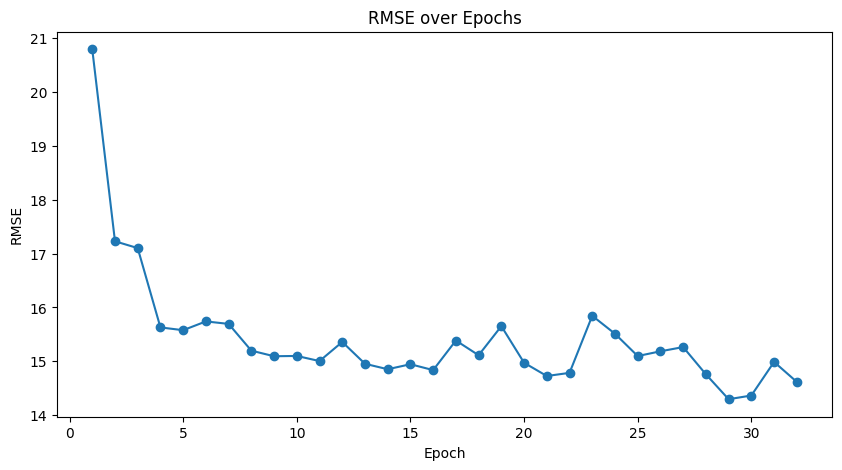

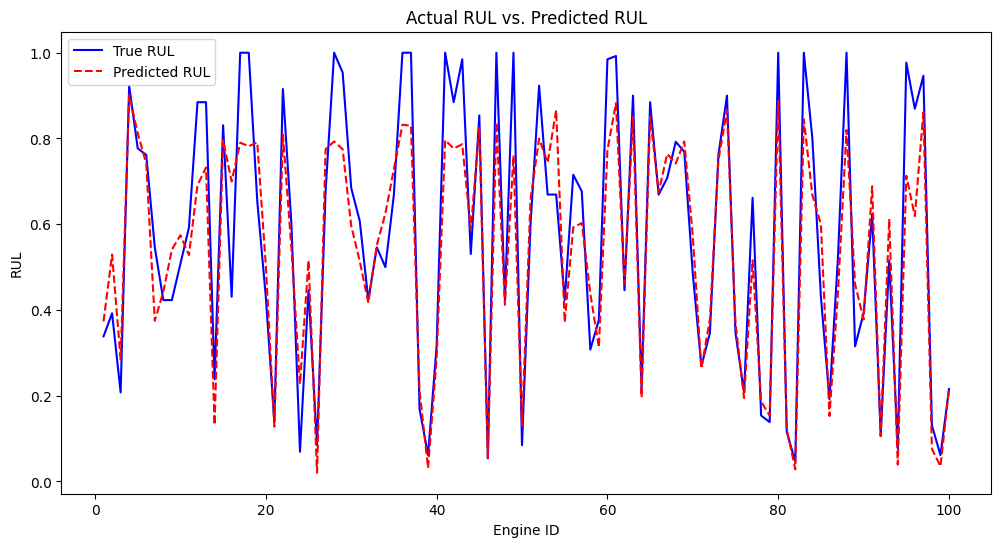

In [ ]:
import os

# for directory create it
if not os.path.exists('/content/drive/MyDrive/Datasets/CP1BiGRU/checkpoints'):
    os.makedirs('/content/drive/MyDrive/Datasets/CP1BiGRU/checkpoints')

import torch
import numpy as np
from torch import optim as optim
from torch.utils.data import DataLoader

if __name__ == '__main__':
    # implementation of main file
    trainset = Turbofandataset(mode='train',
                               dataset='/content/drive/MyDrive/Datasets/CP1BiGRU/train_FD003_normed.txt')
    train_loader = DataLoader(dataset=trainset, batch_size=100, shuffle=True, num_workers=2)

    testset = Turbofandataset(mode='test',
                              dataset='/content/drive/MyDrive/Datasets/CP1BiGRU/test_FD003_normed.txt',
                              rul_result='/content/drive/MyDrive/Datasets/CP1BiGRU/RUL_FD003.txt')
    test_loader = DataLoader(dataset=testset, batch_size=64, shuffle=False, num_workers=2)
    print('dataset load successfully!')

    best_score_list = []
    best_RMSE_list = []
    for iteration in range(25):
        print('---Iteration: {}---'.format(iteration + 1))
        model = Model()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        epochs = 32
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        trainer = Trainer(model=model,
                          model_optimizer=optimizer,
                          print_every=50,
                          epochs=epochs,
                          device=device,
                          prefix='FD001')
        best_score, best_RMSE = trainer.train(train_loader, test_loader, iteration)
        best_score_list.append(best_score)
        best_RMSE_list.append(best_RMSE)

    best_score_list = np.array(best_score_list)
    best_RMSE_list = np.array(best_RMSE_list)
    result = np.concatenate((best_score_list, best_RMSE_list)).reshape(2, 25)
    np.savetxt('/content/drive/MyDrive/Datasets/CP1BiGRU/resultFD001.txt'.format(trainer.prefix), result, fmt='%.4f')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
